## Data Preparation

In [1]:
import numpy as np
from tqdm import tqdm
import json
from collections import Counter
from collections import defaultdict
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
# lemmatisation
from nltk.stem import WordNetLemmatizer

In [12]:
dataLines = []
with open("../../Data/reviews.txt") as file:
    for line in tqdm(file):
        if line == " ":
            continue
        dataLines.append(line)

print("Number of lines: ", len(dataLines))

4607047it [00:09, 508640.25it/s]

Number of lines:  4607047


In [13]:
lemma = WordNetLemmatizer()
def lemmatize(dataLines):
    newData = []
    for line in tqdm(dataLines):
        words = line.split()
        for i in range(len(words)):
            words[i] = lemma.lemmatize(words[i])
        newData.append(" ".join(words))
    return newData


def preProcessing(dataLines,minFreq):
    # lemmatize the data
    # dataLines = lemmatize(dataLines)
    wordCount = defaultdict(int)

    for line in tqdm(dataLines):
        for word in line.split():
            wordCount[word] += 1
    newData = []
    # replace with <unk> if frequency is less than minFreq
    for line in tqdm(dataLines):
        words = line.split()
        for i in range(len(words)):
            if wordCount[words[i]] < minFreq:
                words[i] = '<UNK>'
        newData.append(" ".join(words))


    # save the dataLines in review.txt
    with open("../../Data/preProcess.txt", "w") as file:
        for line in newData:
            file.write(line + "\n")

    return newData

datalines = preProcessing(dataLines[:200000],500)


100%|██████████| 200000/200000 [00:05<00:00, 37257.73it/s]


In [5]:
wordDict = defaultdict(int)
with open("../../Data/preProcess.txt") as file:
    for line in tqdm(file):
        for word in line.split():
            wordDict[word] += 1

# print("Number of lines: ", len(dataLines))
# save in temp file the wordDict
with open("./wordDict.txt", "w") as file:
    for word, count in wordDict.items():
        file.write(word + " " + str(count) + "\n")

        


4607047it [02:15, 33879.24it/s]


In [4]:
from nltk.tokenize import word_tokenize

class SVD:
    def __init__(self,window_size, cutoff, data):
        self.data = data
        self.window_size = window_size
        self.cutoff = cutoff
        self.wordDict = defaultdict(int)
        self.wordCount = 0
        self.minfreq = 200
        self.word2id = {}
        self.id2word = {}
        self.vocab = []
        self.vocabSize = 0
        self.cooccur = defaultdict(int)
        self.cooccurMatrix = None
        self.wordTokens = []
        self.U = None
        self.S = None
        self.V = None
        self.dim = 0
        self.createVocab()
        self.createCooccurMatrix()
        self.createSVD()
        self.saveEmbeddings()


    def createVocab(self):
        for sent in tqdm(self.data):
            words = sent.split()
            self.wordTokens.append(words)
            for word in sent.split():
                self.wordDict[word] += 1
                self.wordCount += 1
            if self.wordCount%1000000 == 0:
                print("Number of words processed: ", self.wordCount)
        
        self.vocab = list(self.wordDict.keys())
        print("Vocab size: ", len(self.vocab))

        with open("wordTokens.txt","w") as f:
            for sent in self.wordTokens:
                f.write(" ".join(sent) + "\n")
        
        print("Tokens created")
        self.vocabSize = len(self.vocab)
        self.cooccurMatrix = sparse.lil_matrix((self.vocabSize,self.vocabSize))

        with open("vocab.txt","w") as f:
            for ind,word in enumerate(self.vocab):
                self.word2id[word] = ind
                self.id2word[ind] = word
                f.write(word + " " + str(self.wordDict[word]) + "\n")
        print("Vocab created")

    def createCooccurMatrix(self):
        with open("wordTokens.txt" , "r") as f:
            for line in tqdm(f):
                line = line.split()
                first_window = line[:self.window_size]
                if self.window_size > len(line):
                    continue
                for t,word in enumerate(line[:-self.window_size]):
                    word_ind = self.word2id[word]
                    first_window = first_window[1:] + [line[t+self.window_size]]
                    for context_word in first_window:
                        context_ind = self.word2id[context_word]
                        try:
                            self.cooccurMatrix[word_ind,context_ind] += 1
                        except:
                            self.cooccurMatrix[word_ind,context_ind] = 1
                        try:
                            self.cooccurMatrix[context_ind,word_ind] += 1
                        except:
                            self.cooccurMatrix[context_ind,word_ind] = 1

        print("Cooccurrence matrix created")

    def createSVD(self):
        u,s,v = sparse.linalg.svds(self.cooccurMatrix,which='LM',k=100)
        print(u.shape,s.shape,v.shape)
        deno = sum(s)
        sum_count = 0
        # maximum variance cutoff
        for i,x in enumerate(s):
            sum_count += x
            if sum_count/deno > self.cutoff:
                self.dim = i+1
                break
        self.U = u[:,:self.dim]
        self.S = s[:self.dim]
        self.V = v[:self.dim,:]

        # normalise
        norms_u = np.linalg.norm(self.U, axis=1, keepdims=True)
        self.U = np.where(norms_u < 1e-8, self.U, self.U / (norms_u + 1e-8))

        norms_v = np.linalg.norm(self.V, axis=1, keepdims=True)
        self.V = np.where(norms_v < 1e-8, self.V, self.V / (norms_v + 1e-8))

        print("SVD done")

    def saveEmbeddings(self):
        with open("embeddings.txt","w") as f:
            for word,vec in zip(self.vocab,self.U):
                f.write(word + " " + " ".join([str(x) for x in vec]) + "\n")




In [5]:
svd_ = SVD(7, 0.9, datalines[:100000])


100%|██████████| 100000/100000 [00:08<00:00, 12300.83it/s]


Vocab size:  7346
Tokens created
Vocab created


100000it [12:26, 133.88it/s]


Cooccurrence matrix created
(7346, 100) (100,) (100, 7346)
SVD done


In [160]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance



# load the SVD matrix
svd_matrix = []
feature_list = []
with open("embeddings.txt") as file:
    for line in file:
        svd_matrix.append([float(x) for x in line.strip('\n').split(" ")[1:]])
        feature_list.append(line.strip('\n').split(" ")[0])

svd_matrix = np.array(svd_matrix)





In [195]:
def colorBars(words, token_list,svd_matrix, fileName):
    fig, axs = plt.subplots(nrows=len(words), ncols=1,
                            figsize=(20, 2*len(words)))
    color = ['brown','red', 'orange', 'yellow',
             'white', 'cyan', 'blue', 'purple','black']
    for i, word in enumerate(words):
        word_ind = token_list.index(word)
        vec = svd_matrix[word_ind]
        vec = vec/np.linalg.norm(vec)
        axs[i].bar(range(100), vec, color=color)
        axs[i].set_title(word)

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()

def plot_top_10_words(word,token_list,svd_matrix):
    def tsne_plot(results):
        words = [x[0] for x in results]
        tokens = [x[1] for x in results]
        words = np.array(words)
        tokens = np.array(tokens)

        tsne_model = TSNE(init='pca',perplexity=2,random_state=42,method='exact',n_iter=1000,metric='cosine')
        res_embeds = tsne_model.fit_transform(tokens)

        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]

        plt.figure(figsize=(10,10))
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i],y_axis[i])
            plt.annotate(words[i],xy=(x_axis[i],y_axis[i]),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
        # plt.savefig('./Results/' + word+'.png')
    
    if word not in token_list:
        print("Word not in vocab")
        word = '<UNK>'
    word_index = token_list.index(word)
    word_vector = svd_matrix[word_index]
    res = {}
    for i,embed in tqdm(enumerate(svd_matrix)):
        if i!=word_index:
            magnitude_product = np.linalg.norm(
               embed) * np.linalg.norm(word_vector)
            if magnitude_product == 0:
                res[i] = [np.nan, embed]
            else:
                cosine_distance = 1-distance.cosine(embed, word_vector)
                # euclidean_distance = distance.euclidean(embed, word_vector)
            res[i] = [cosine_distance, embed]

    results = sorted(res.items(), key=lambda x: x[1][0], reverse=True)[:10]
    results = [(token_list[x[0]],x[1][1]) for x in results]

    print('Word: ', word)
    # print(results)
    print('Top 10 similar words: ', [x[0] for x in results])
    print_words = []
    print_words.append(word)
    for i in range(10):
        print_words.append(results[i][0])
    file_name = './Results/ '+word + "_bar.png"
    # colorBars(print_words, token_list,svd_matrix, file_name)
    # tsne_plot(results)
    return results


25089it [00:01, 15514.00it/s]


Word:  they
Top 10 similar words:  ['colonist', 'themselves', 'their', 'oftentimes', 'handcuffed', 'crop', 'visibly', 'stereotypically', 'chevalier', 'otis']


[('colonist',
  array([-0.16864064,  0.09610187, -0.04369086,  0.0571779 , -0.17735279,
          0.18646877,  0.06656281, -0.13835033, -0.16867011,  0.24842481,
         -0.09720736,  0.01984352, -0.11462908, -0.18241679,  0.24895402,
          0.02057753, -0.00762665, -0.21076447, -0.01737176,  0.00665723,
          0.16923298, -0.0010886 , -0.01967677, -0.00188798, -0.14398764,
          0.13424916,  0.01745044,  0.02305306, -0.03246635,  0.10333056,
         -0.00897653, -0.04472753,  0.1656233 , -0.15675813,  0.08280858,
         -0.04164335, -0.0783193 ,  0.14284541, -0.09820209, -0.14203023,
          0.14194447,  0.00302952, -0.1057913 ,  0.14259173, -0.01875494,
         -0.00681738,  0.10348946, -0.10435546,  0.07106367,  0.15167537,
         -0.11081916,  0.13886978,  0.01238243, -0.02120252,  0.13233534,
          0.10558469, -0.10758181,  0.01426993,  0.06310785,  0.08716119,
          0.07614259,  0.00865539, -0.06629353, -0.09117486,  0.03067243,
          0.14669234, -0

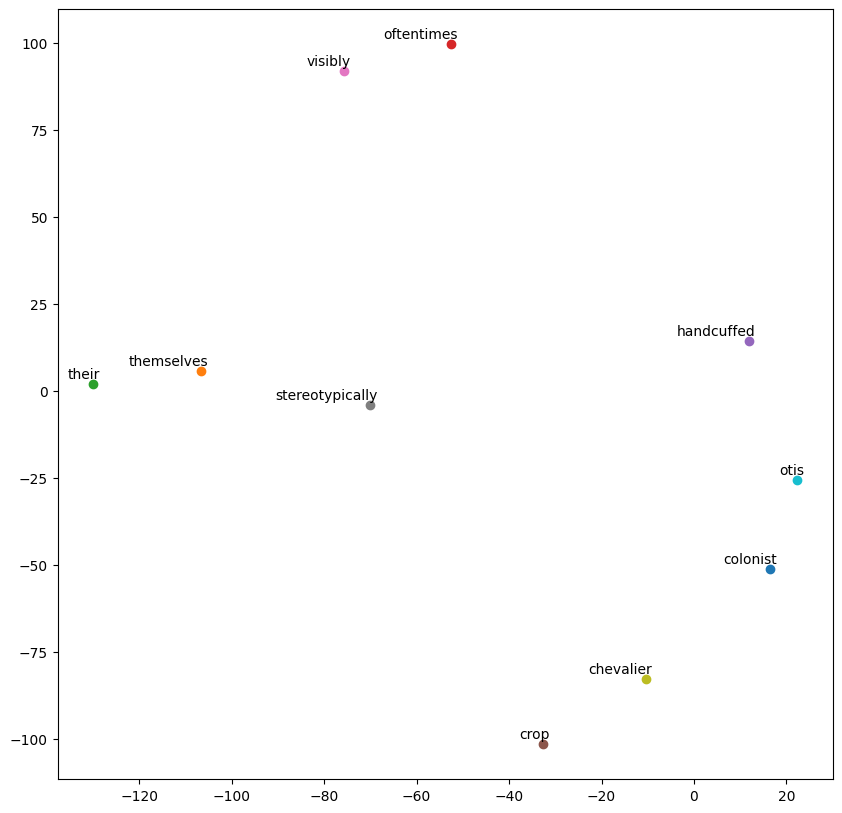

In [192]:
plot_top_10_words('they', feature_list, svd_matrix)


25089it [00:01, 20797.96it/s]


Word:  america
Top 10 similar words:  ['china', 'europe', 'angeles', 'japan', 'mid', 'italy', 'london', '1943', 'australia', 'france']


25089it [00:01, 19202.89it/s]


Word:  watch
Top 10 similar words:  ['rewatch', 'see', 'watched', 'goblet', 'reload', 'relax', 'rewind', 'relive', 'replay', 'analyze']


25089it [00:01, 24253.45it/s]


Word:  they
Top 10 similar words:  ['colonist', 'themselves', 'their', 'oftentimes', 'handcuffed', 'crop', 'visibly', 'stereotypically', 'chevalier', 'otis']


25089it [00:01, 15109.37it/s]


Word:  well
Top 10 similar words:  ['professionally', 'nicely', 'poorly', 'tastefully', 'harpo', 'beautifully', 'believeable', 'plotted', 'xmen', 'cheaply']


25089it [00:01, 15730.96it/s]


Word:  funny
Top 10 similar words:  ['scary', 'entertaining', 'sad', 'hilarious', 'sexy', 'clever', 'cool', 'suspensful', 'touching', 'cute']


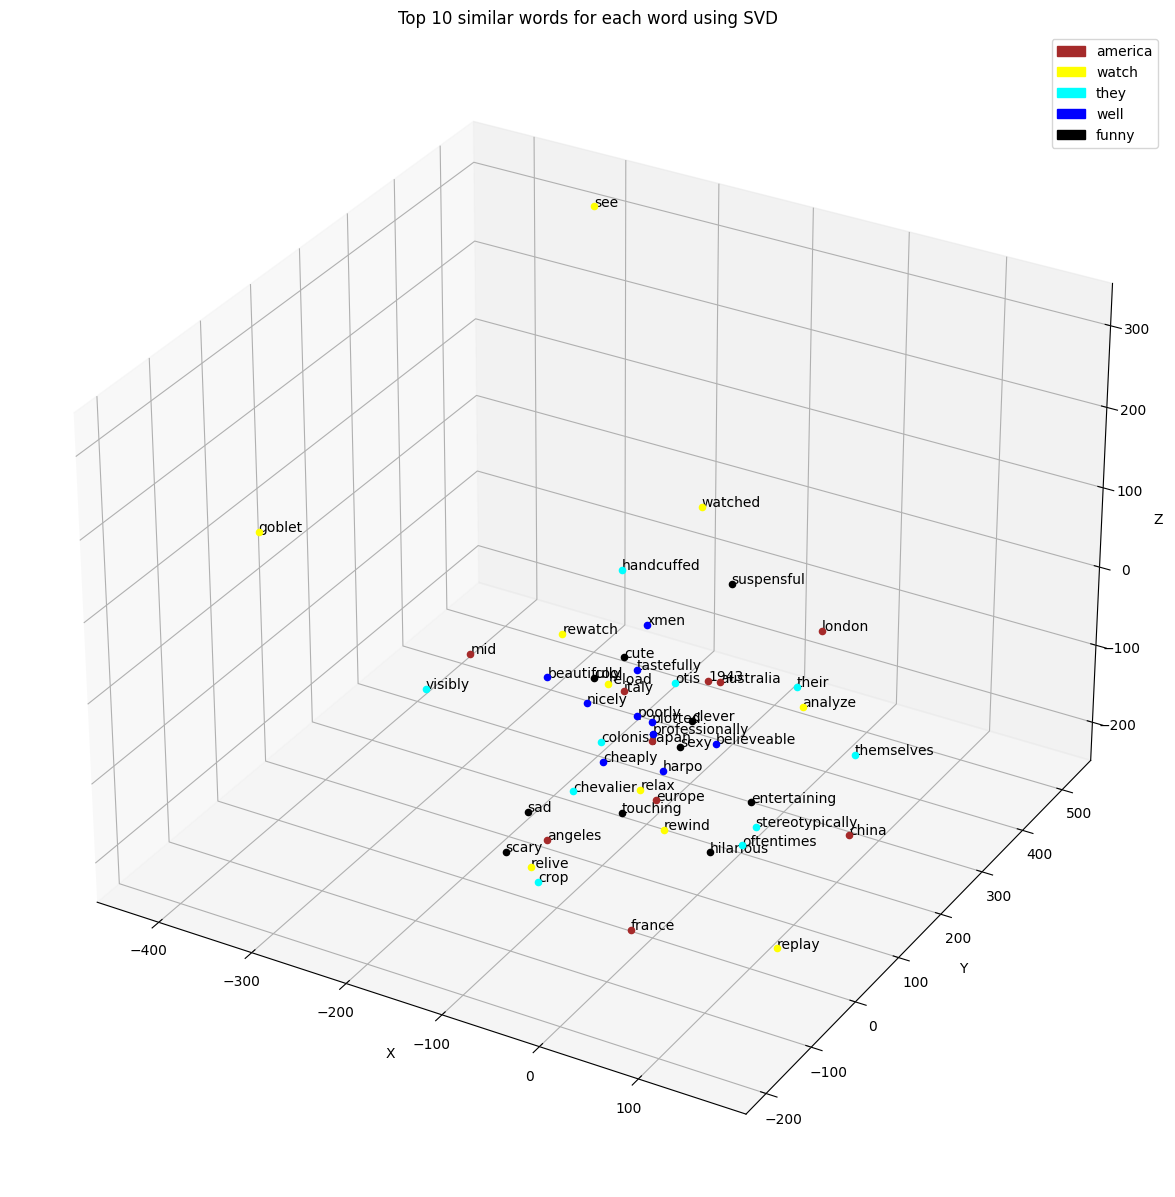

In [199]:


totResults = []
words = ['america', 'watch', 'they', 'well', 'funny']
for word in words:
    totResults.append(plot_top_10_words(word, feature_list, svd_matrix))
    # break
#
# plot the top 10 words for each word in words
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
colorsForWord = ['brown', 'yellow', 'cyan', 'blue', 'black']
wordColorDict = dict(zip(words, colorsForWord))
labelForWords = ['america', 'watch', 'they', 'well', 'funny']
# ax.legend(words)
for i, word in enumerate(labelForWords):
    # similiar ressults of one word in one color all in one plot
    # one plot for all words
    words = [x[0] for x in totResults[i]]
    tokens = [x[1] for x in totResults[i]]
    words = np.array(words)
    tokens = np.array(tokens)

    tsne_model = TSNE(n_components=3, init='pca', perplexity=2,
                      metric='cosine', method='exact', random_state=42)
    res_embeds = tsne_model.fit_transform(tokens)

    x_axis = res_embeds[:, 0]
    y_axis = res_embeds[:, 1]
    z_axis = res_embeds[:, 2]

    # print(x_axis)
    # print(y_axis)
    for j in range(len(x_axis)):
        color = wordColorDict[word]
        ax.scatter(x_axis[j], y_axis[j], z_axis[j], color=color)
        ax.text(x_axis[j], y_axis[j], z_axis[j],
                words[j], size=10, zorder=1, color='k')
# plt.savefig('./Results/' + 'all_words.png')
# legend for color
handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in colorsForWord]
labels = labelForWords
ax.legend(handles, labels)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Top 10 similar words for each word using SVD')


25089it [00:00, 25247.84it/s]


Word:  funny
Top 10 similar words:  ['scary', 'entertaining', 'sad', 'hilarious', 'sexy', 'clever', 'cool', 'suspensful', 'touching', 'cute']


[('scary',
  array([-4.05349401e-02, -1.51347909e-01,  2.57278902e-02,  1.65531058e-01,
         -1.43585679e-01, -3.37903801e-01, -9.27024134e-02,  8.38887999e-02,
         -6.87571675e-02, -8.82253472e-03, -1.26252725e-01,  5.94295767e-02,
         -1.89796707e-01, -1.02772378e-01, -8.38434524e-02, -1.21177668e-01,
          1.14911089e-02,  1.36937565e-01,  1.15226895e-01,  9.25113644e-02,
          1.63670930e-01, -2.75740664e-01, -2.36547040e-02,  2.29358545e-02,
         -7.47089458e-02,  3.93007296e-02,  1.48331677e-01, -2.25829977e-01,
         -1.12962958e-01, -2.16473806e-02,  3.30767082e-03,  4.84748050e-02,
         -1.93554996e-01, -2.02808872e-02, -1.07679973e-01, -1.51561980e-01,
         -1.95962929e-02,  1.20224398e-01,  1.13982405e-02,  5.31036190e-02,
         -1.15225455e-01,  7.71507720e-02, -2.07116279e-01,  2.83733199e-02,
          1.91033711e-01,  1.18311893e-01, -1.75501067e-02, -1.58760757e-01,
         -1.16276355e-01, -3.88203743e-02,  6.48633145e-02, -2.23

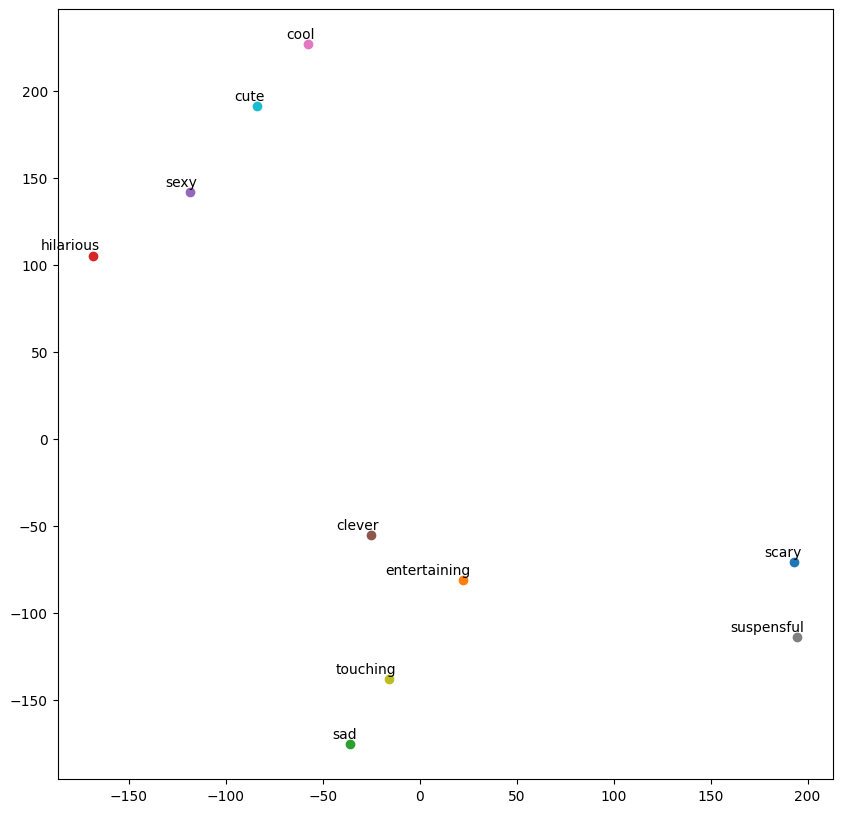

In [162]:
plot_top_10_words('funny', feature_list, svd_matrix)


25089it [00:00, 25681.71it/s]


Word:  boat
Top 10 similar words:  ['navy', 'ship', 'patrol', 'land', 'bomber', 'deck', 'naval', 'sailor', 'submarine', 'ceiling']


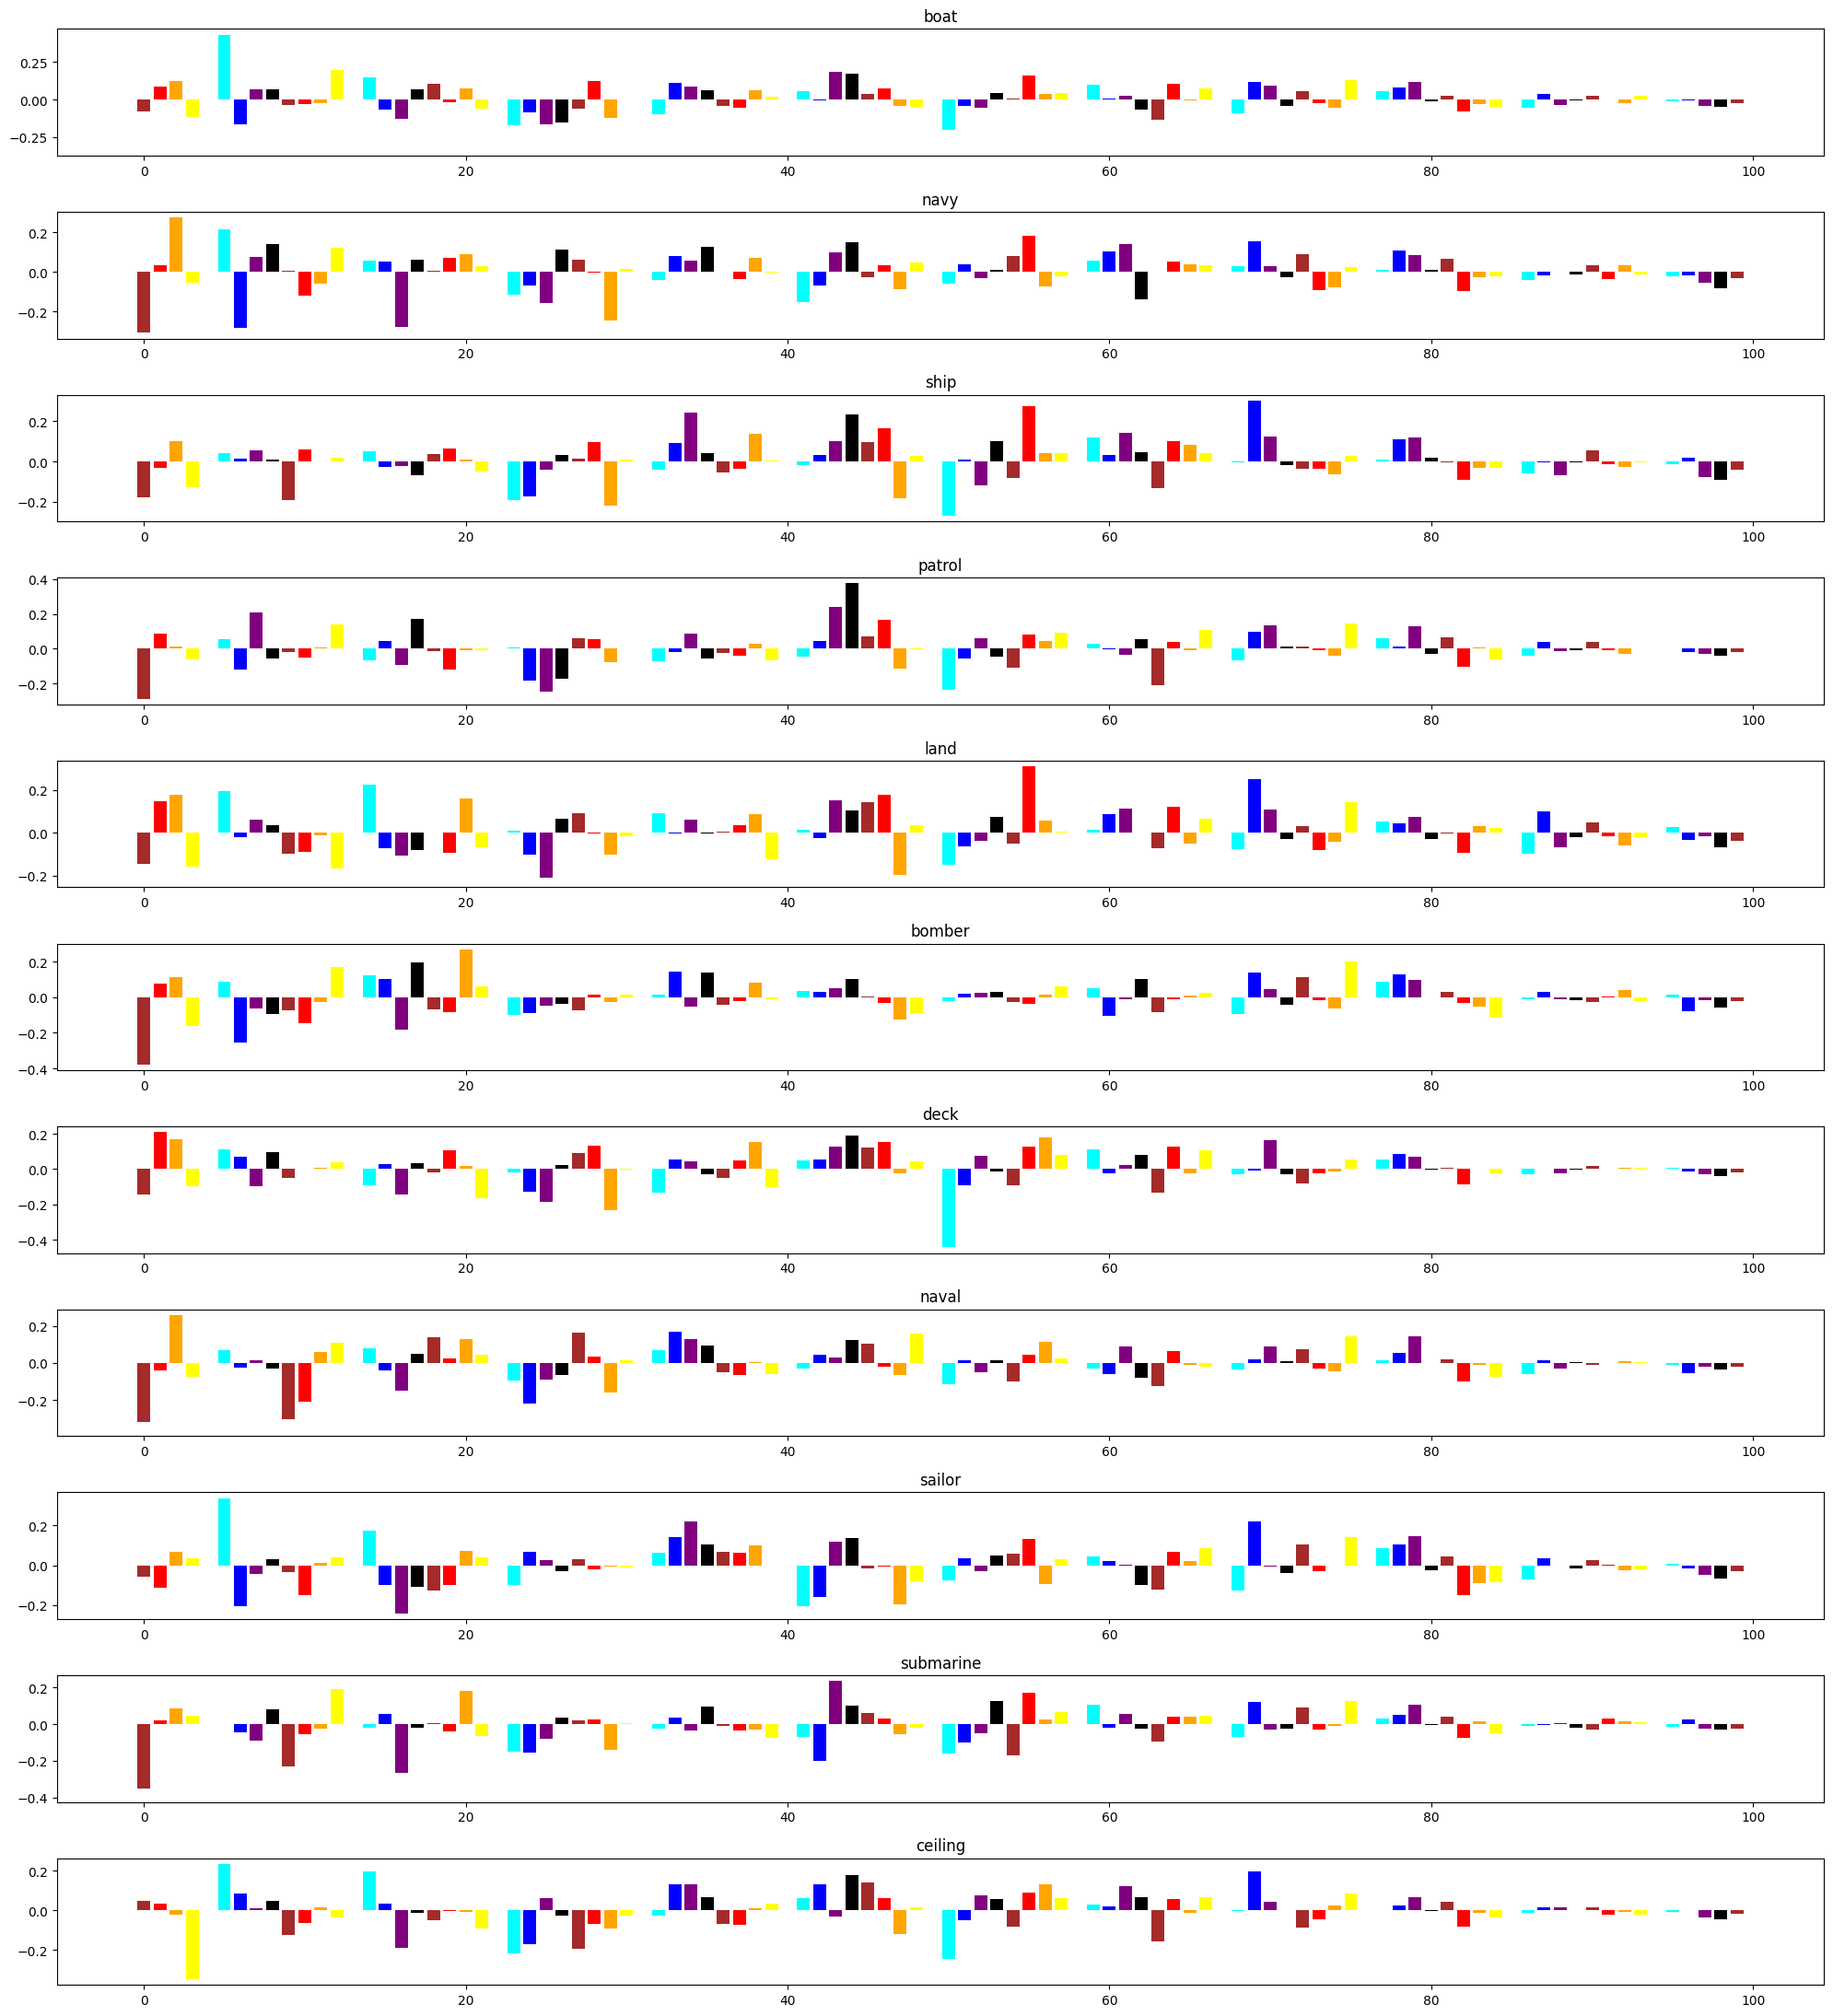

25089it [00:00, 26294.94it/s]


Word:  review
Top 10 similar words:  ['posted', 'reading', 'negative', 'posting', 'positive', 'favorable', 'glowing', 'tt', 'rave', 'editorial']


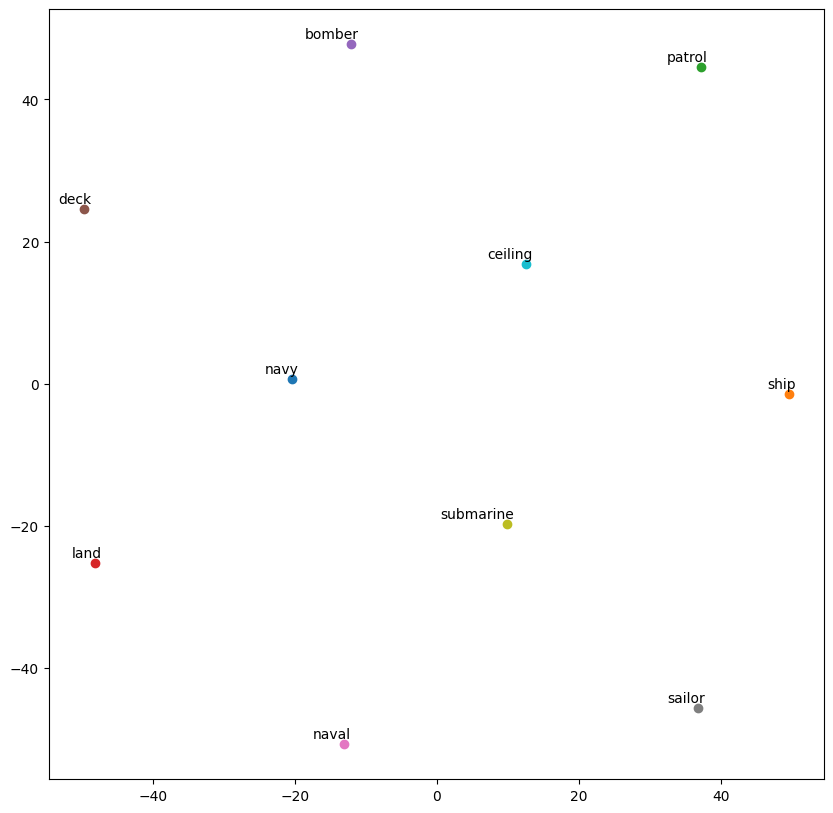

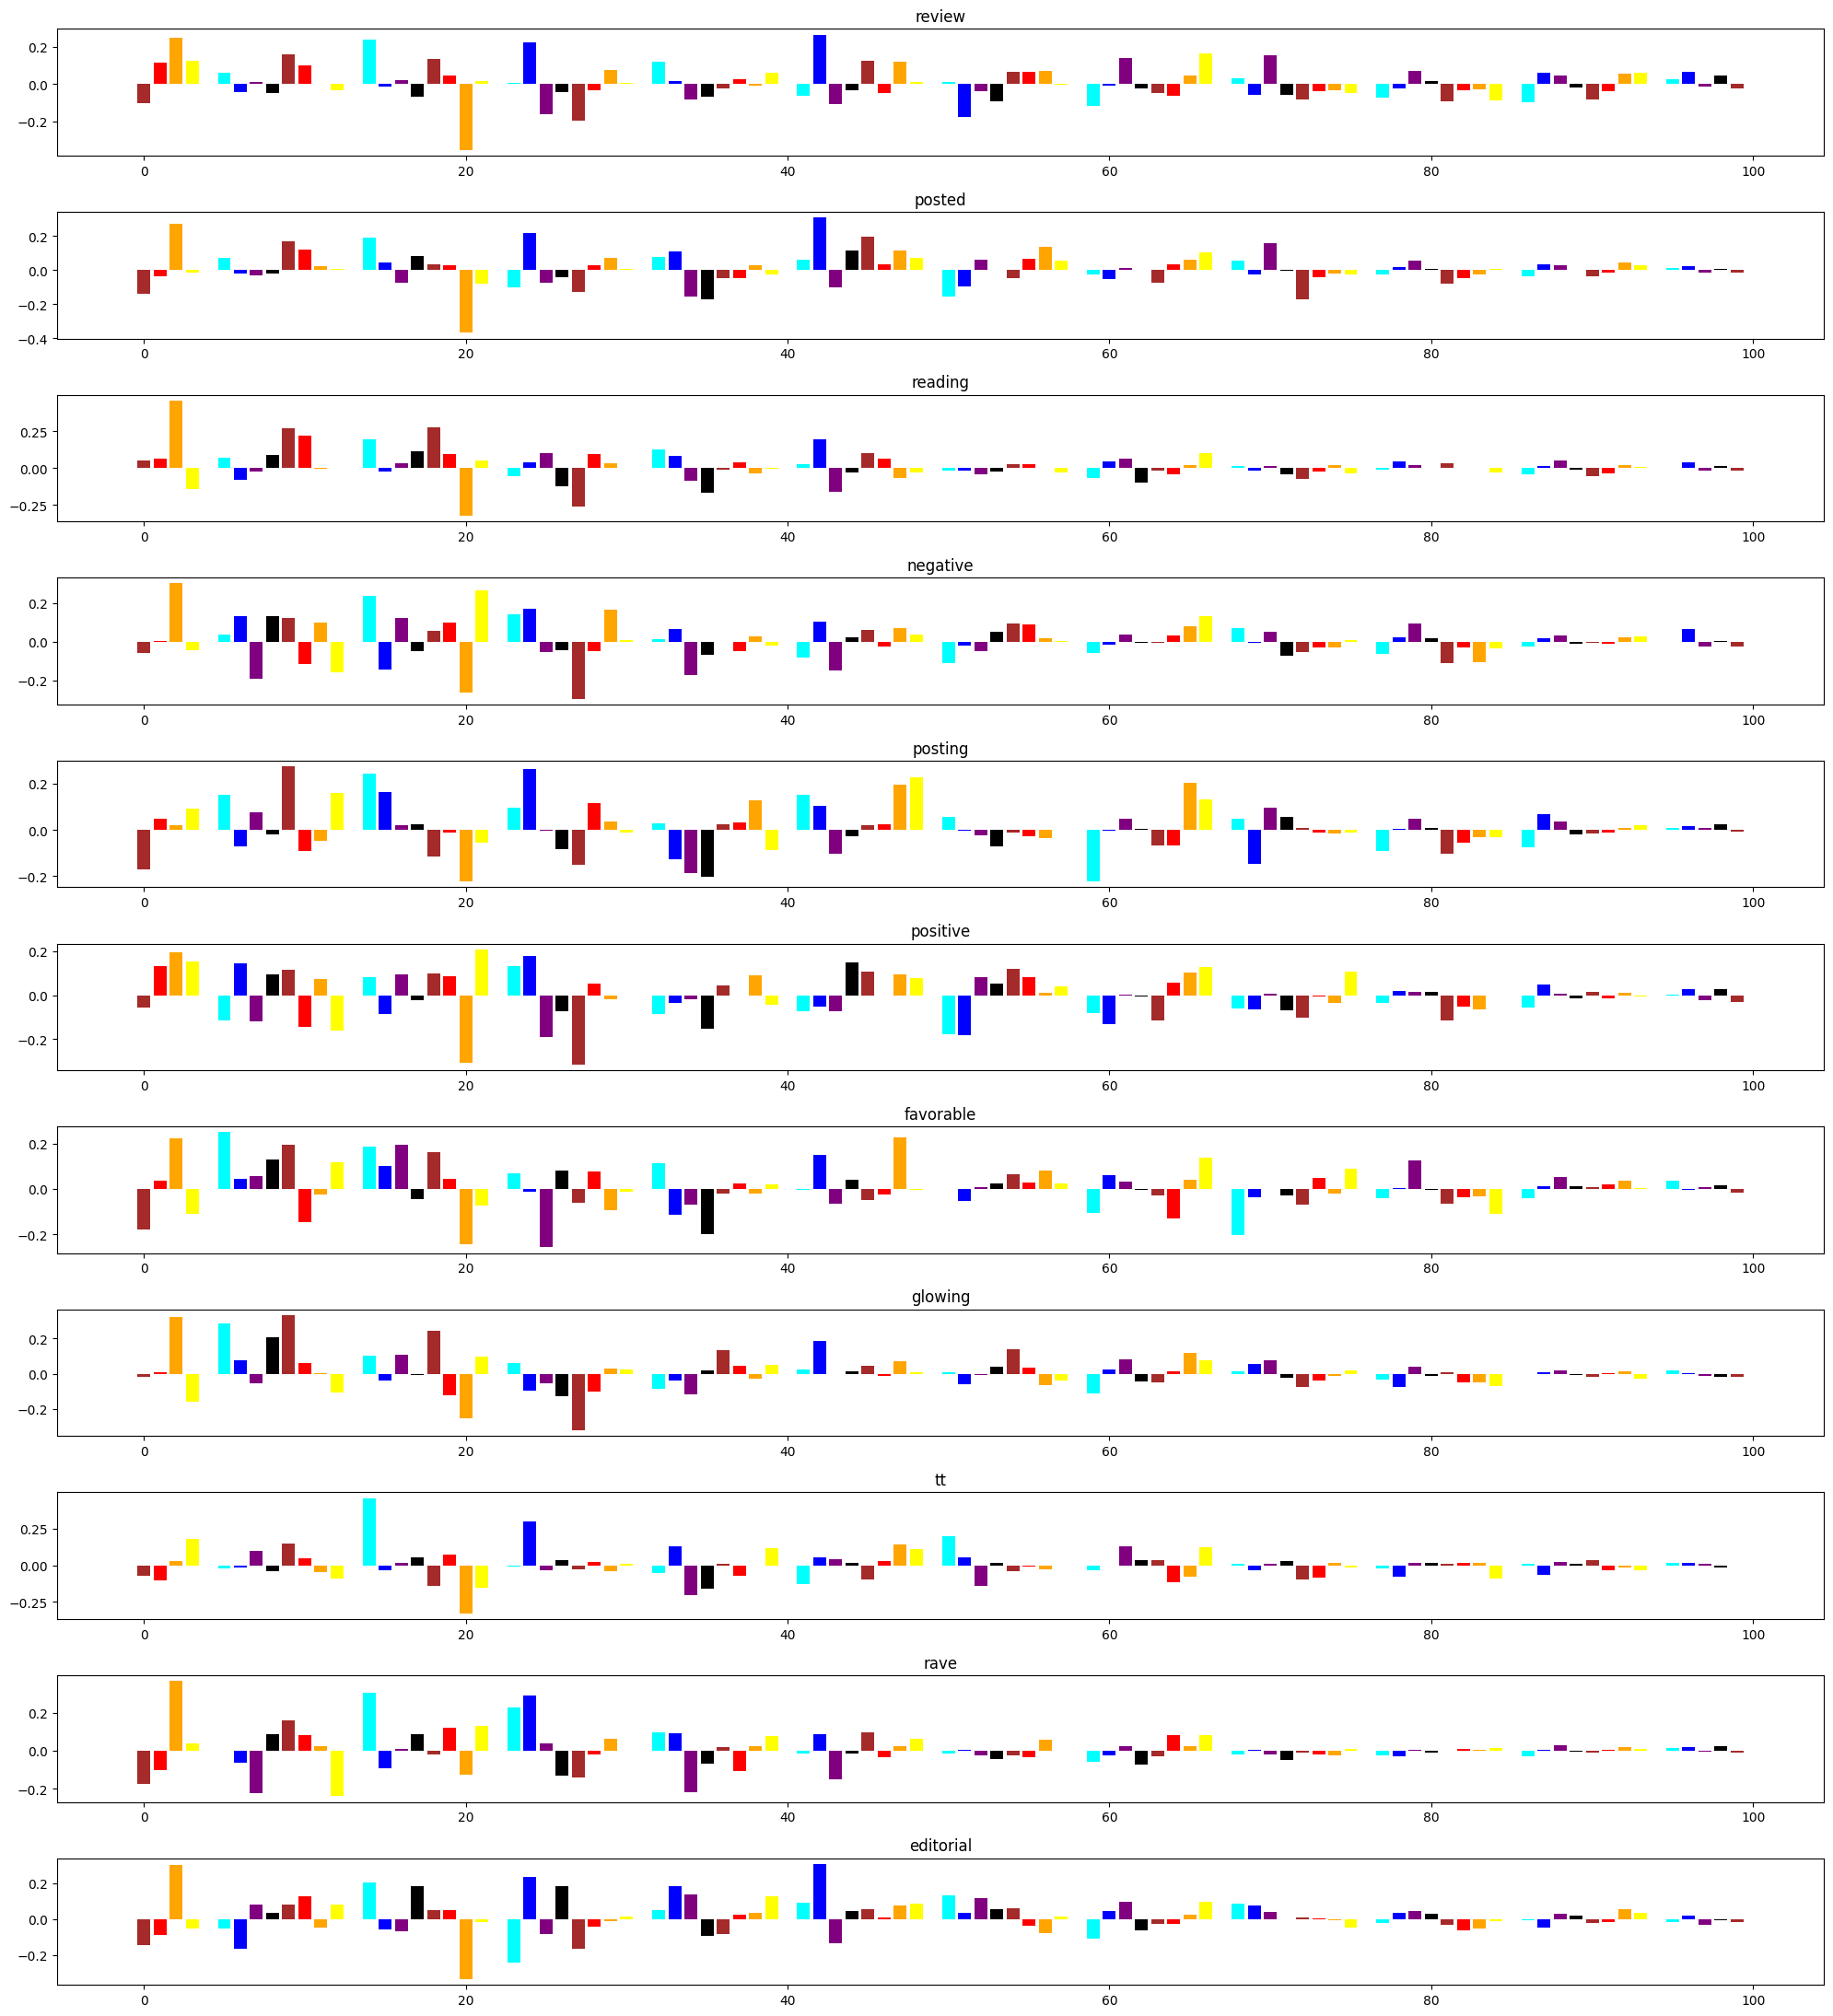

25089it [00:00, 26872.79it/s]


Word:  her
Top 10 similar words:  ['she', 'herself', 'eva', 'boyfriend', 'charlotte', 'shes', 'dolores', 'kidney', 'pregnant', 'seduces']


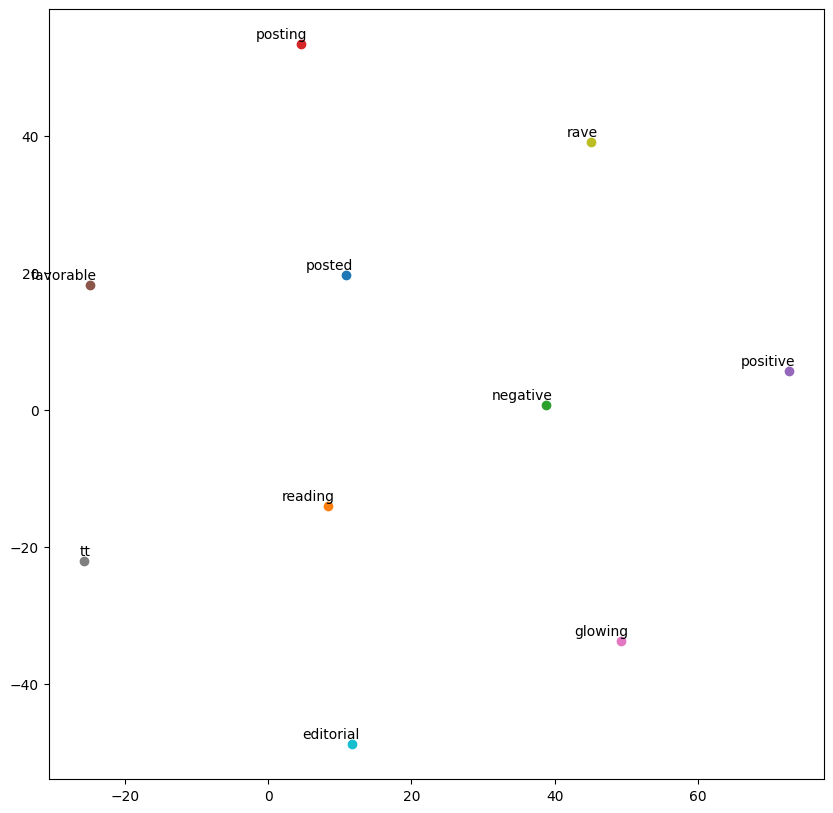

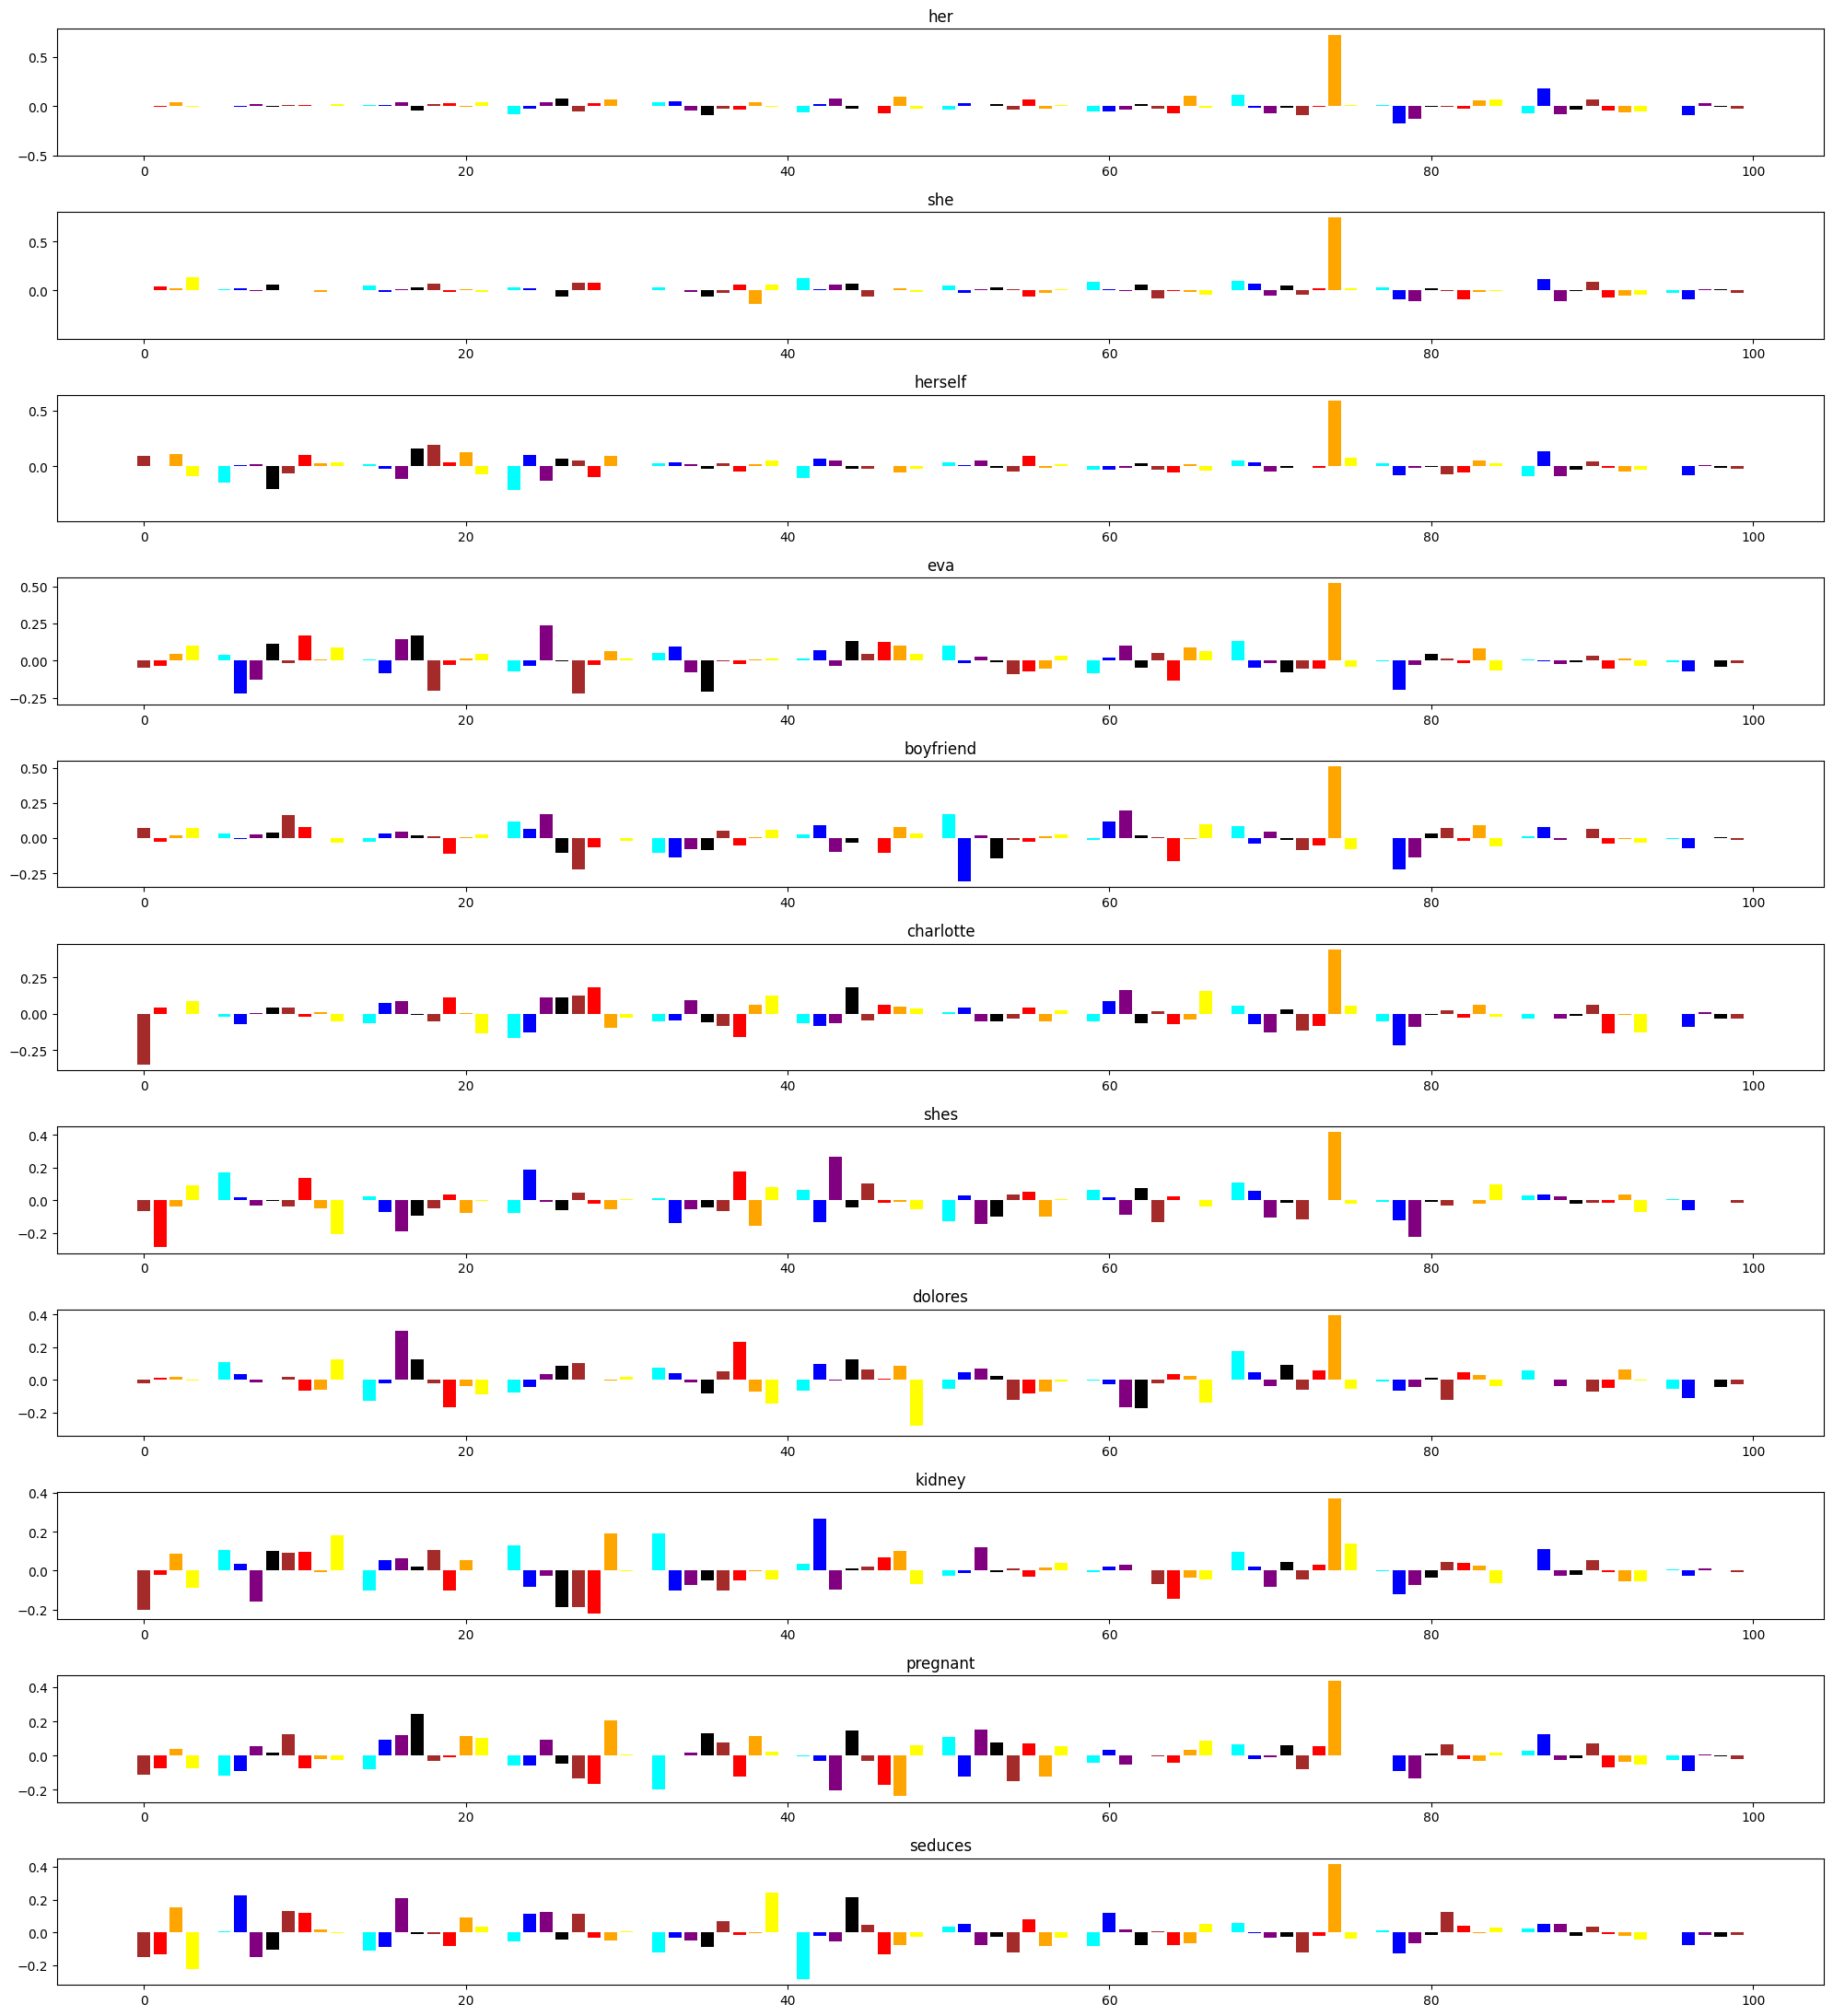

25089it [00:01, 21496.83it/s]


Word:  great
Top 10 similar words:  ['fantastic', 'wonderful', 'terrific', 'fabulous', 'wonderfull', 'macchio', 'splendid', 'classic', 'comeback', 'mcdowall']


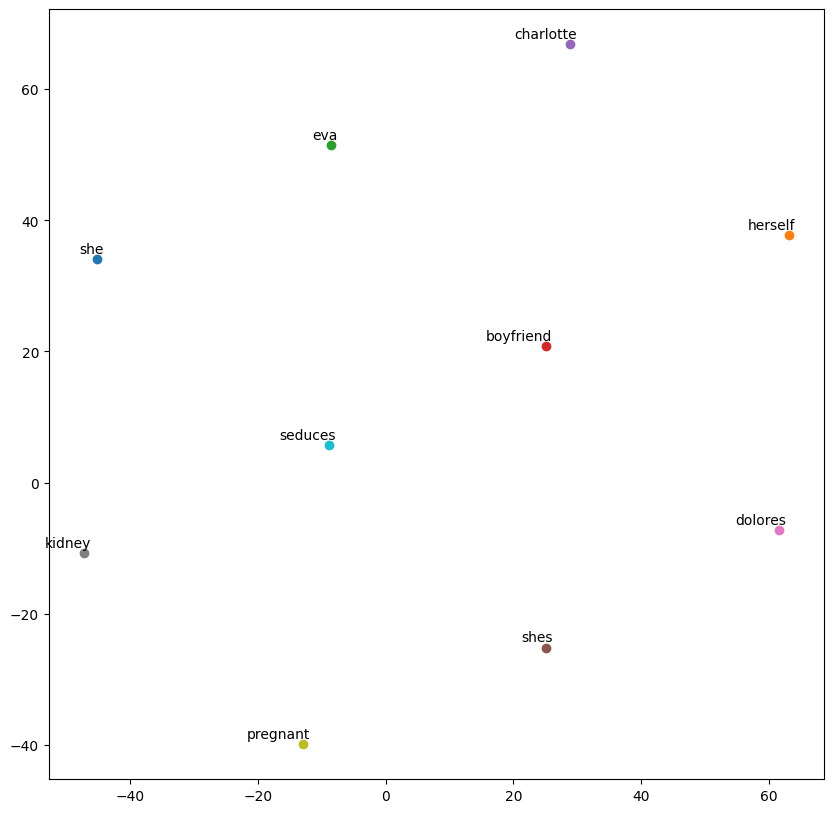

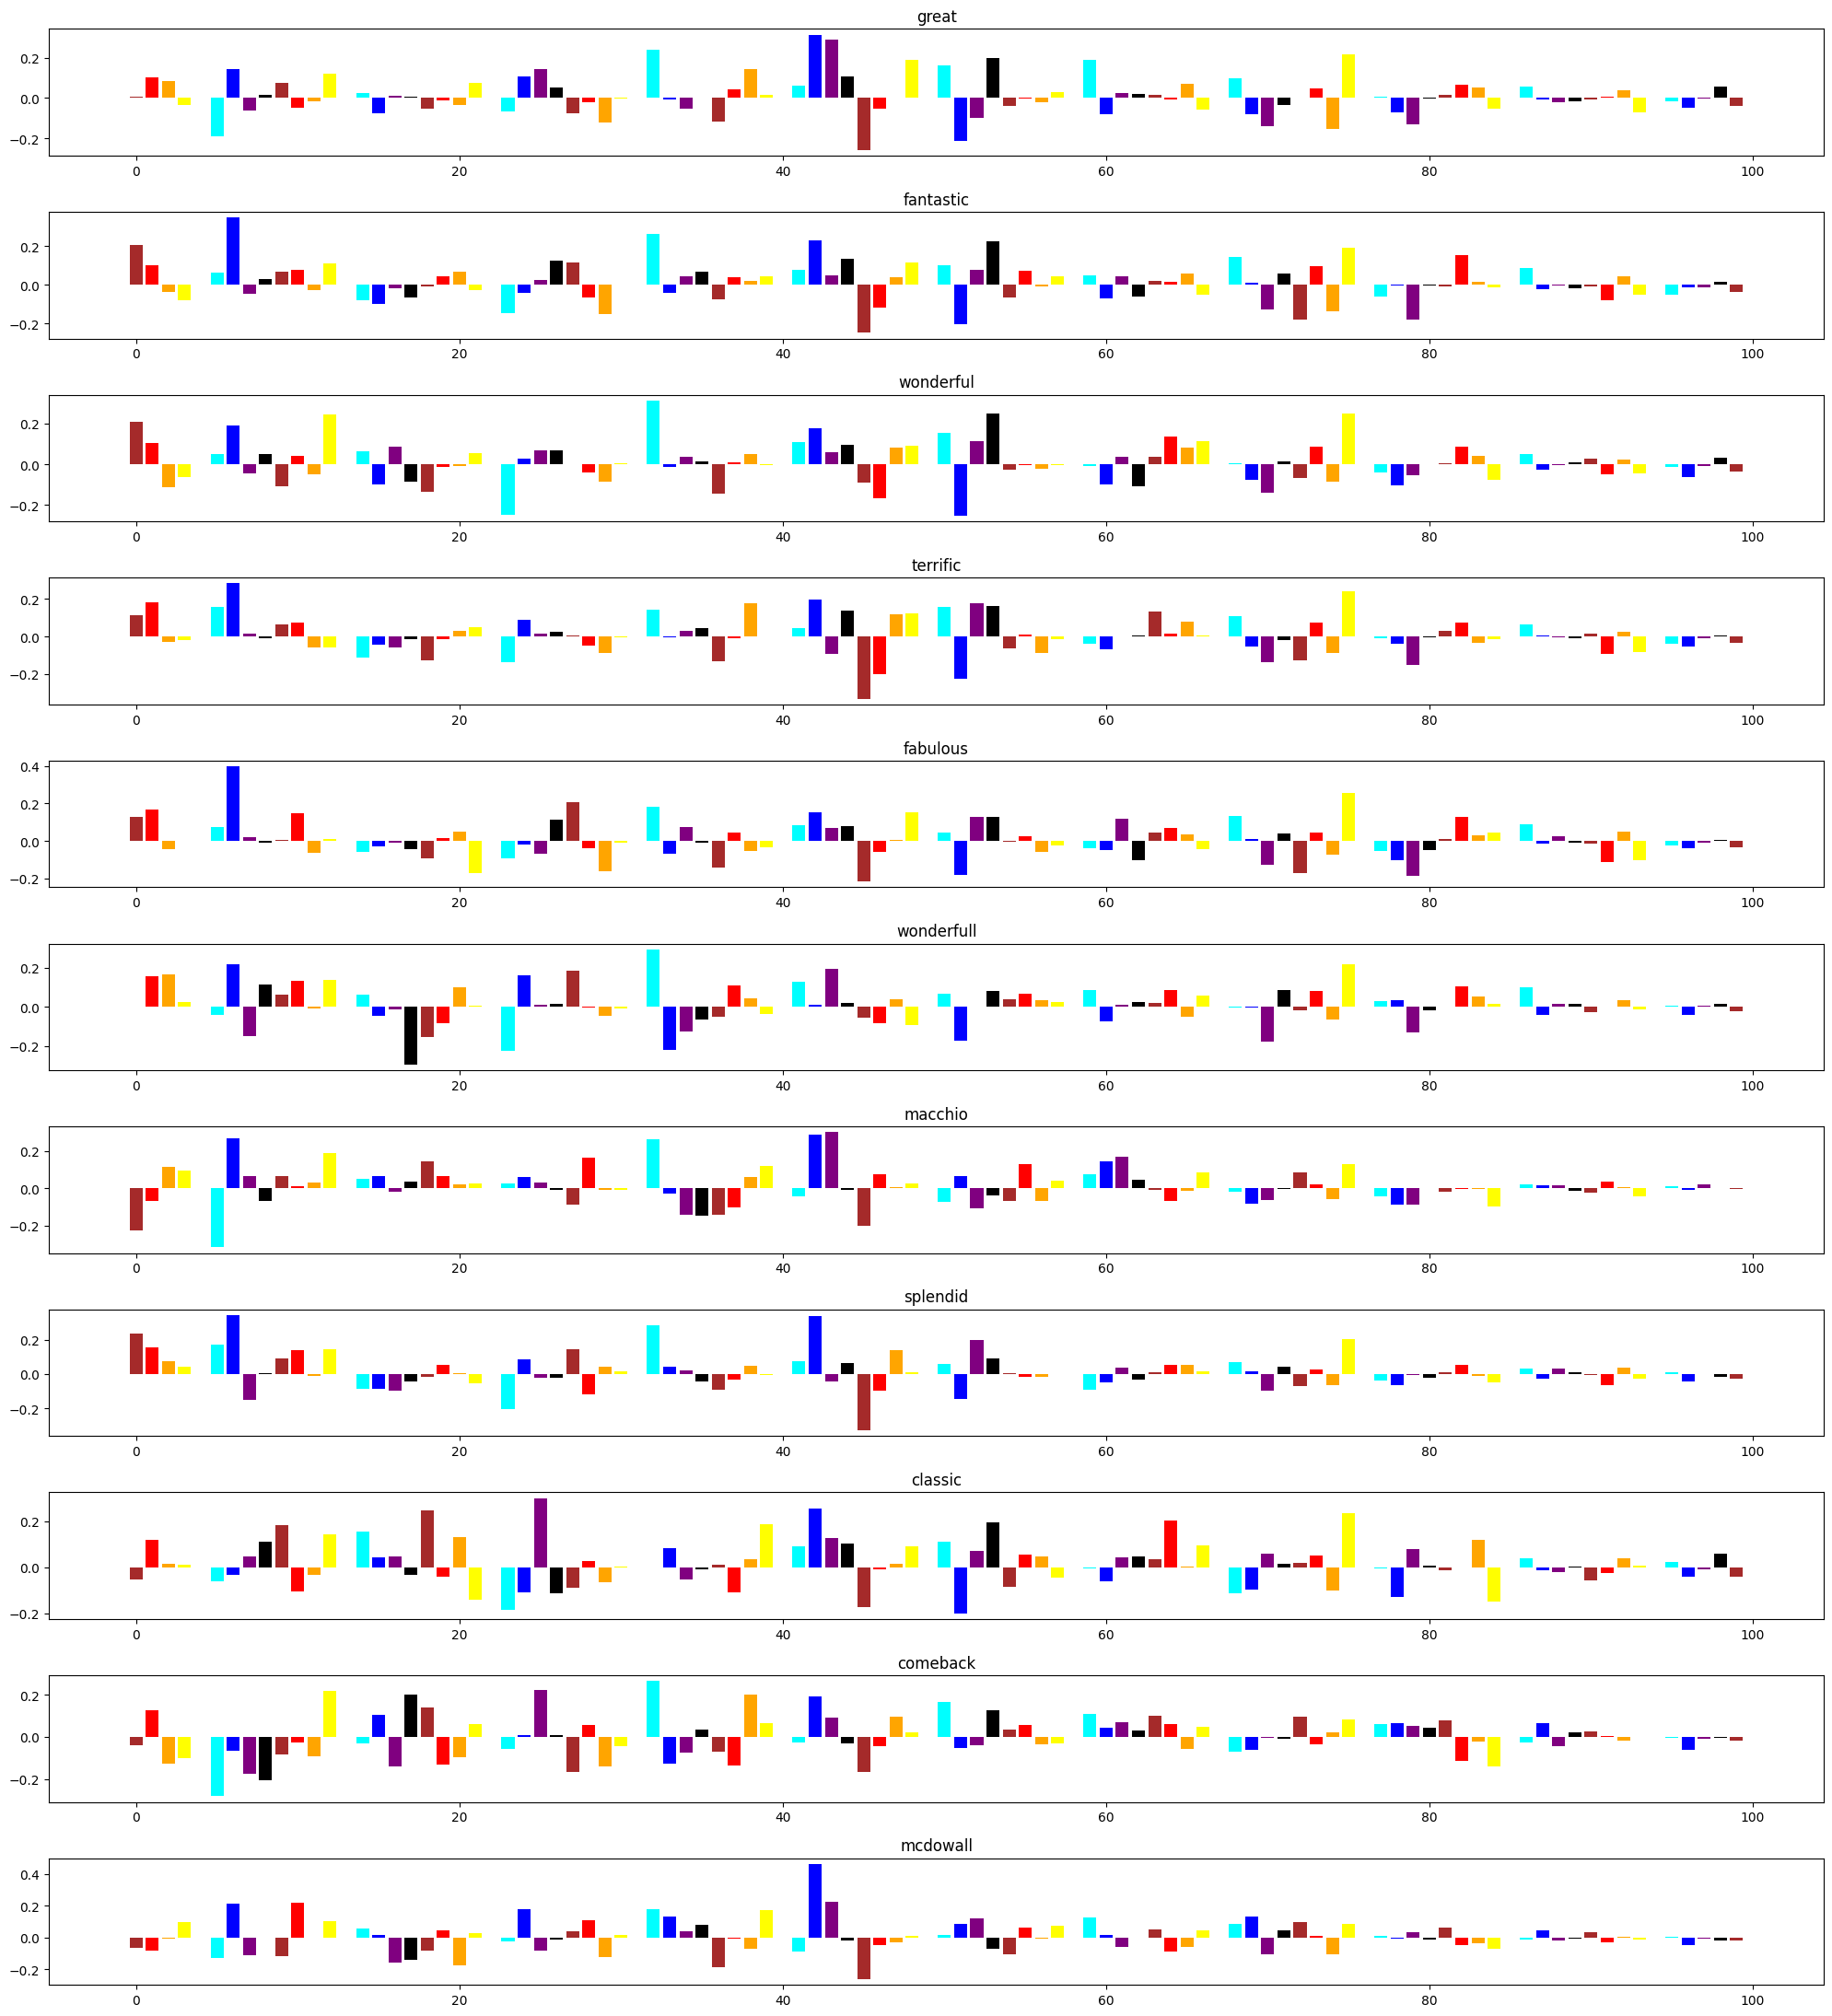

25089it [00:01, 21578.60it/s]


Word:  smart
Top 10 similar words:  ['sexy', 'clever', 'sweet', 'dark', 'witty', 'sensitive', 'funny', 'charming', 'bland', 'cute']


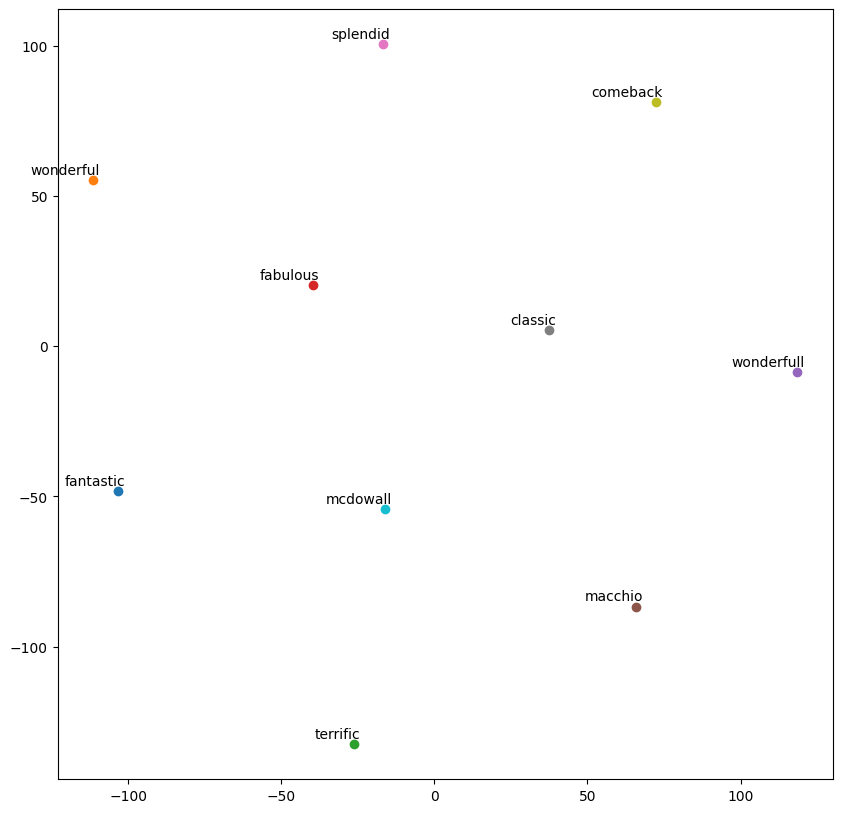

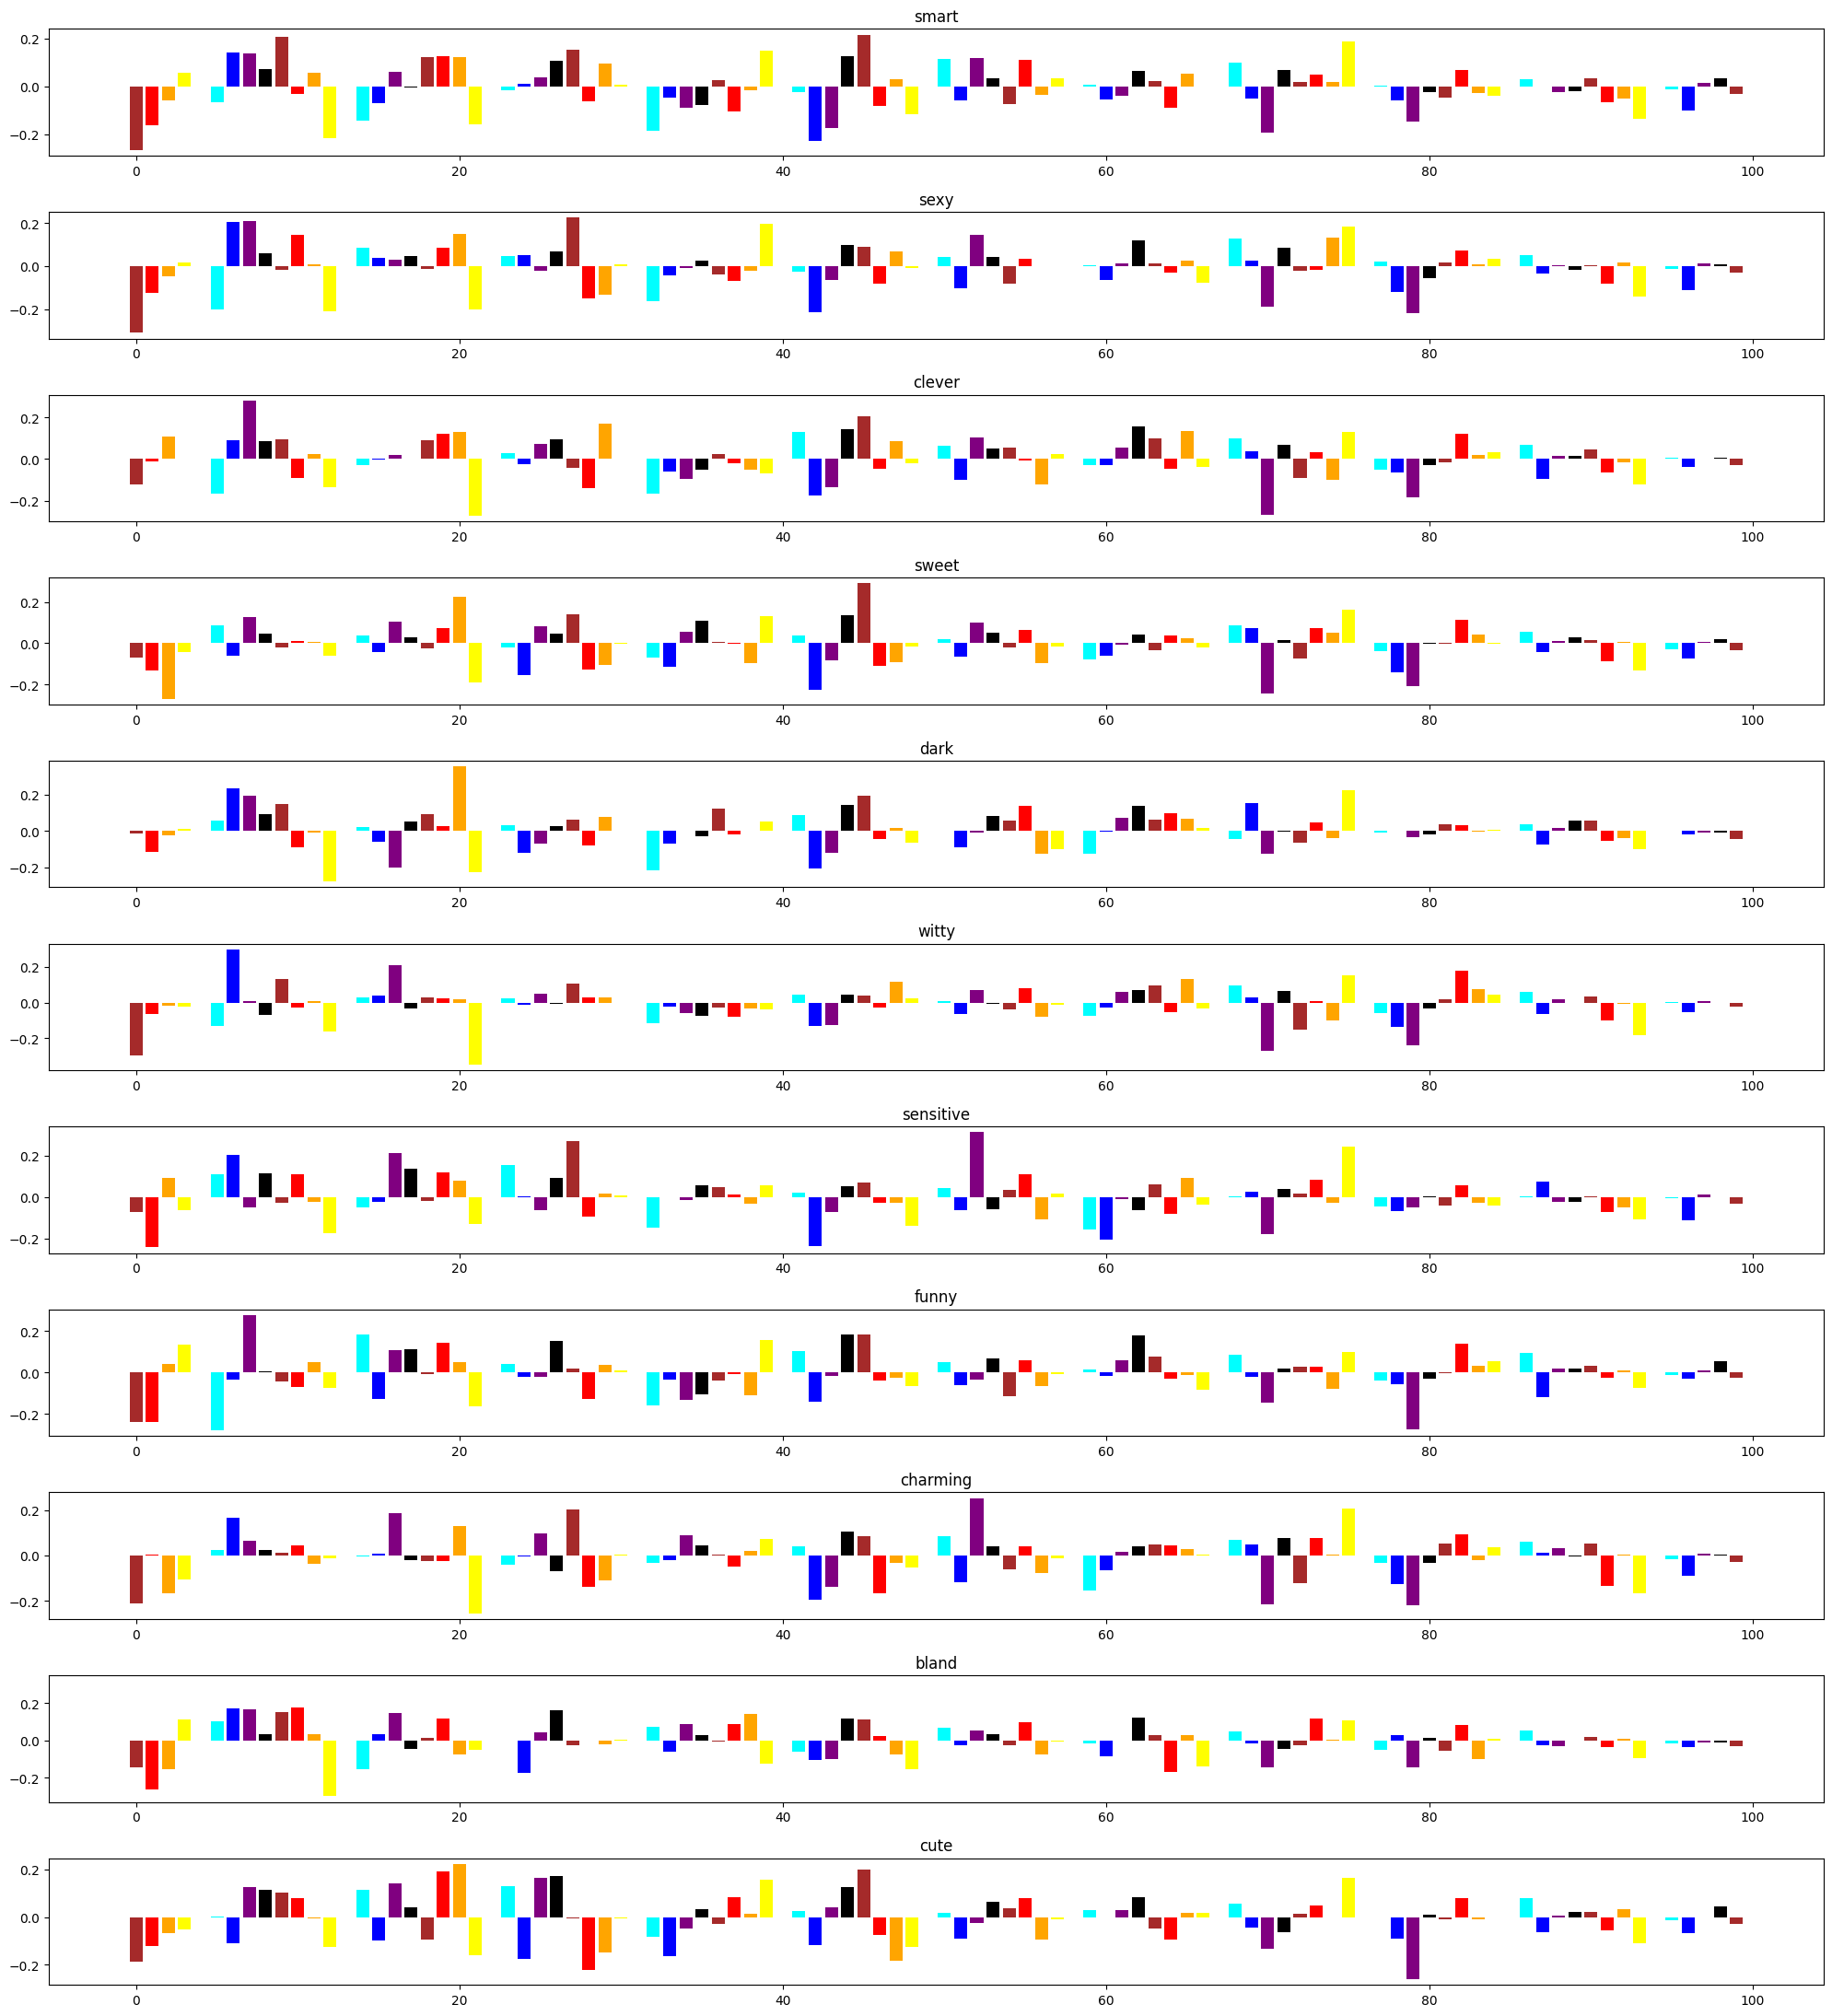

25089it [00:01, 22875.82it/s]


Word:  titanic
Top 10 similar words:  ['holocaust', '1928', 'surrounding', 'voyage', 'sinking', 'bombing', 'apollo', 'bulk', 'matrix', 'crux']


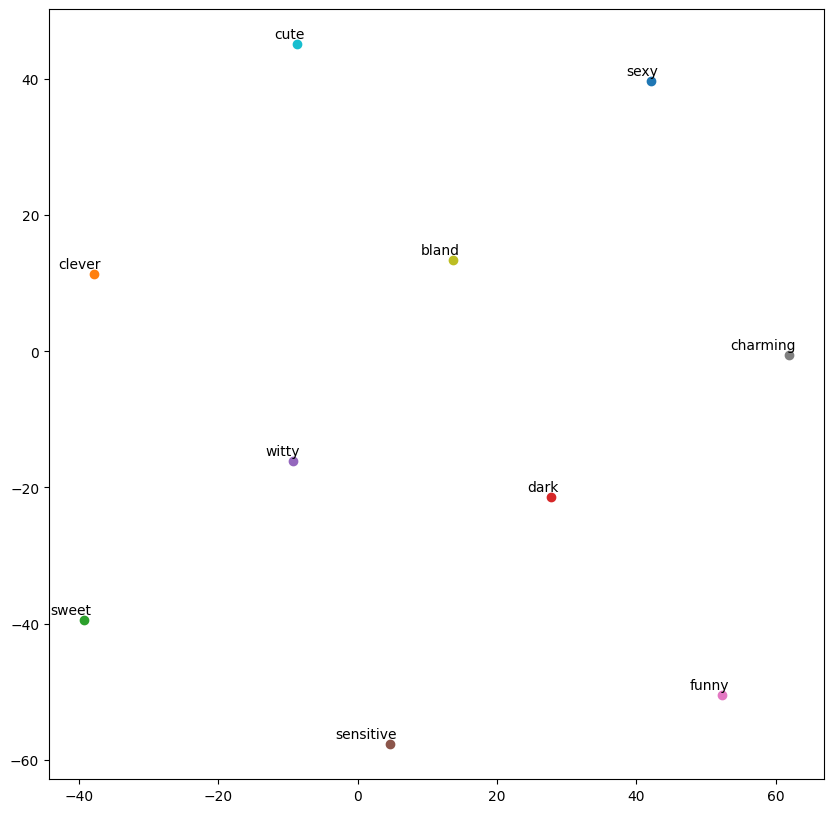

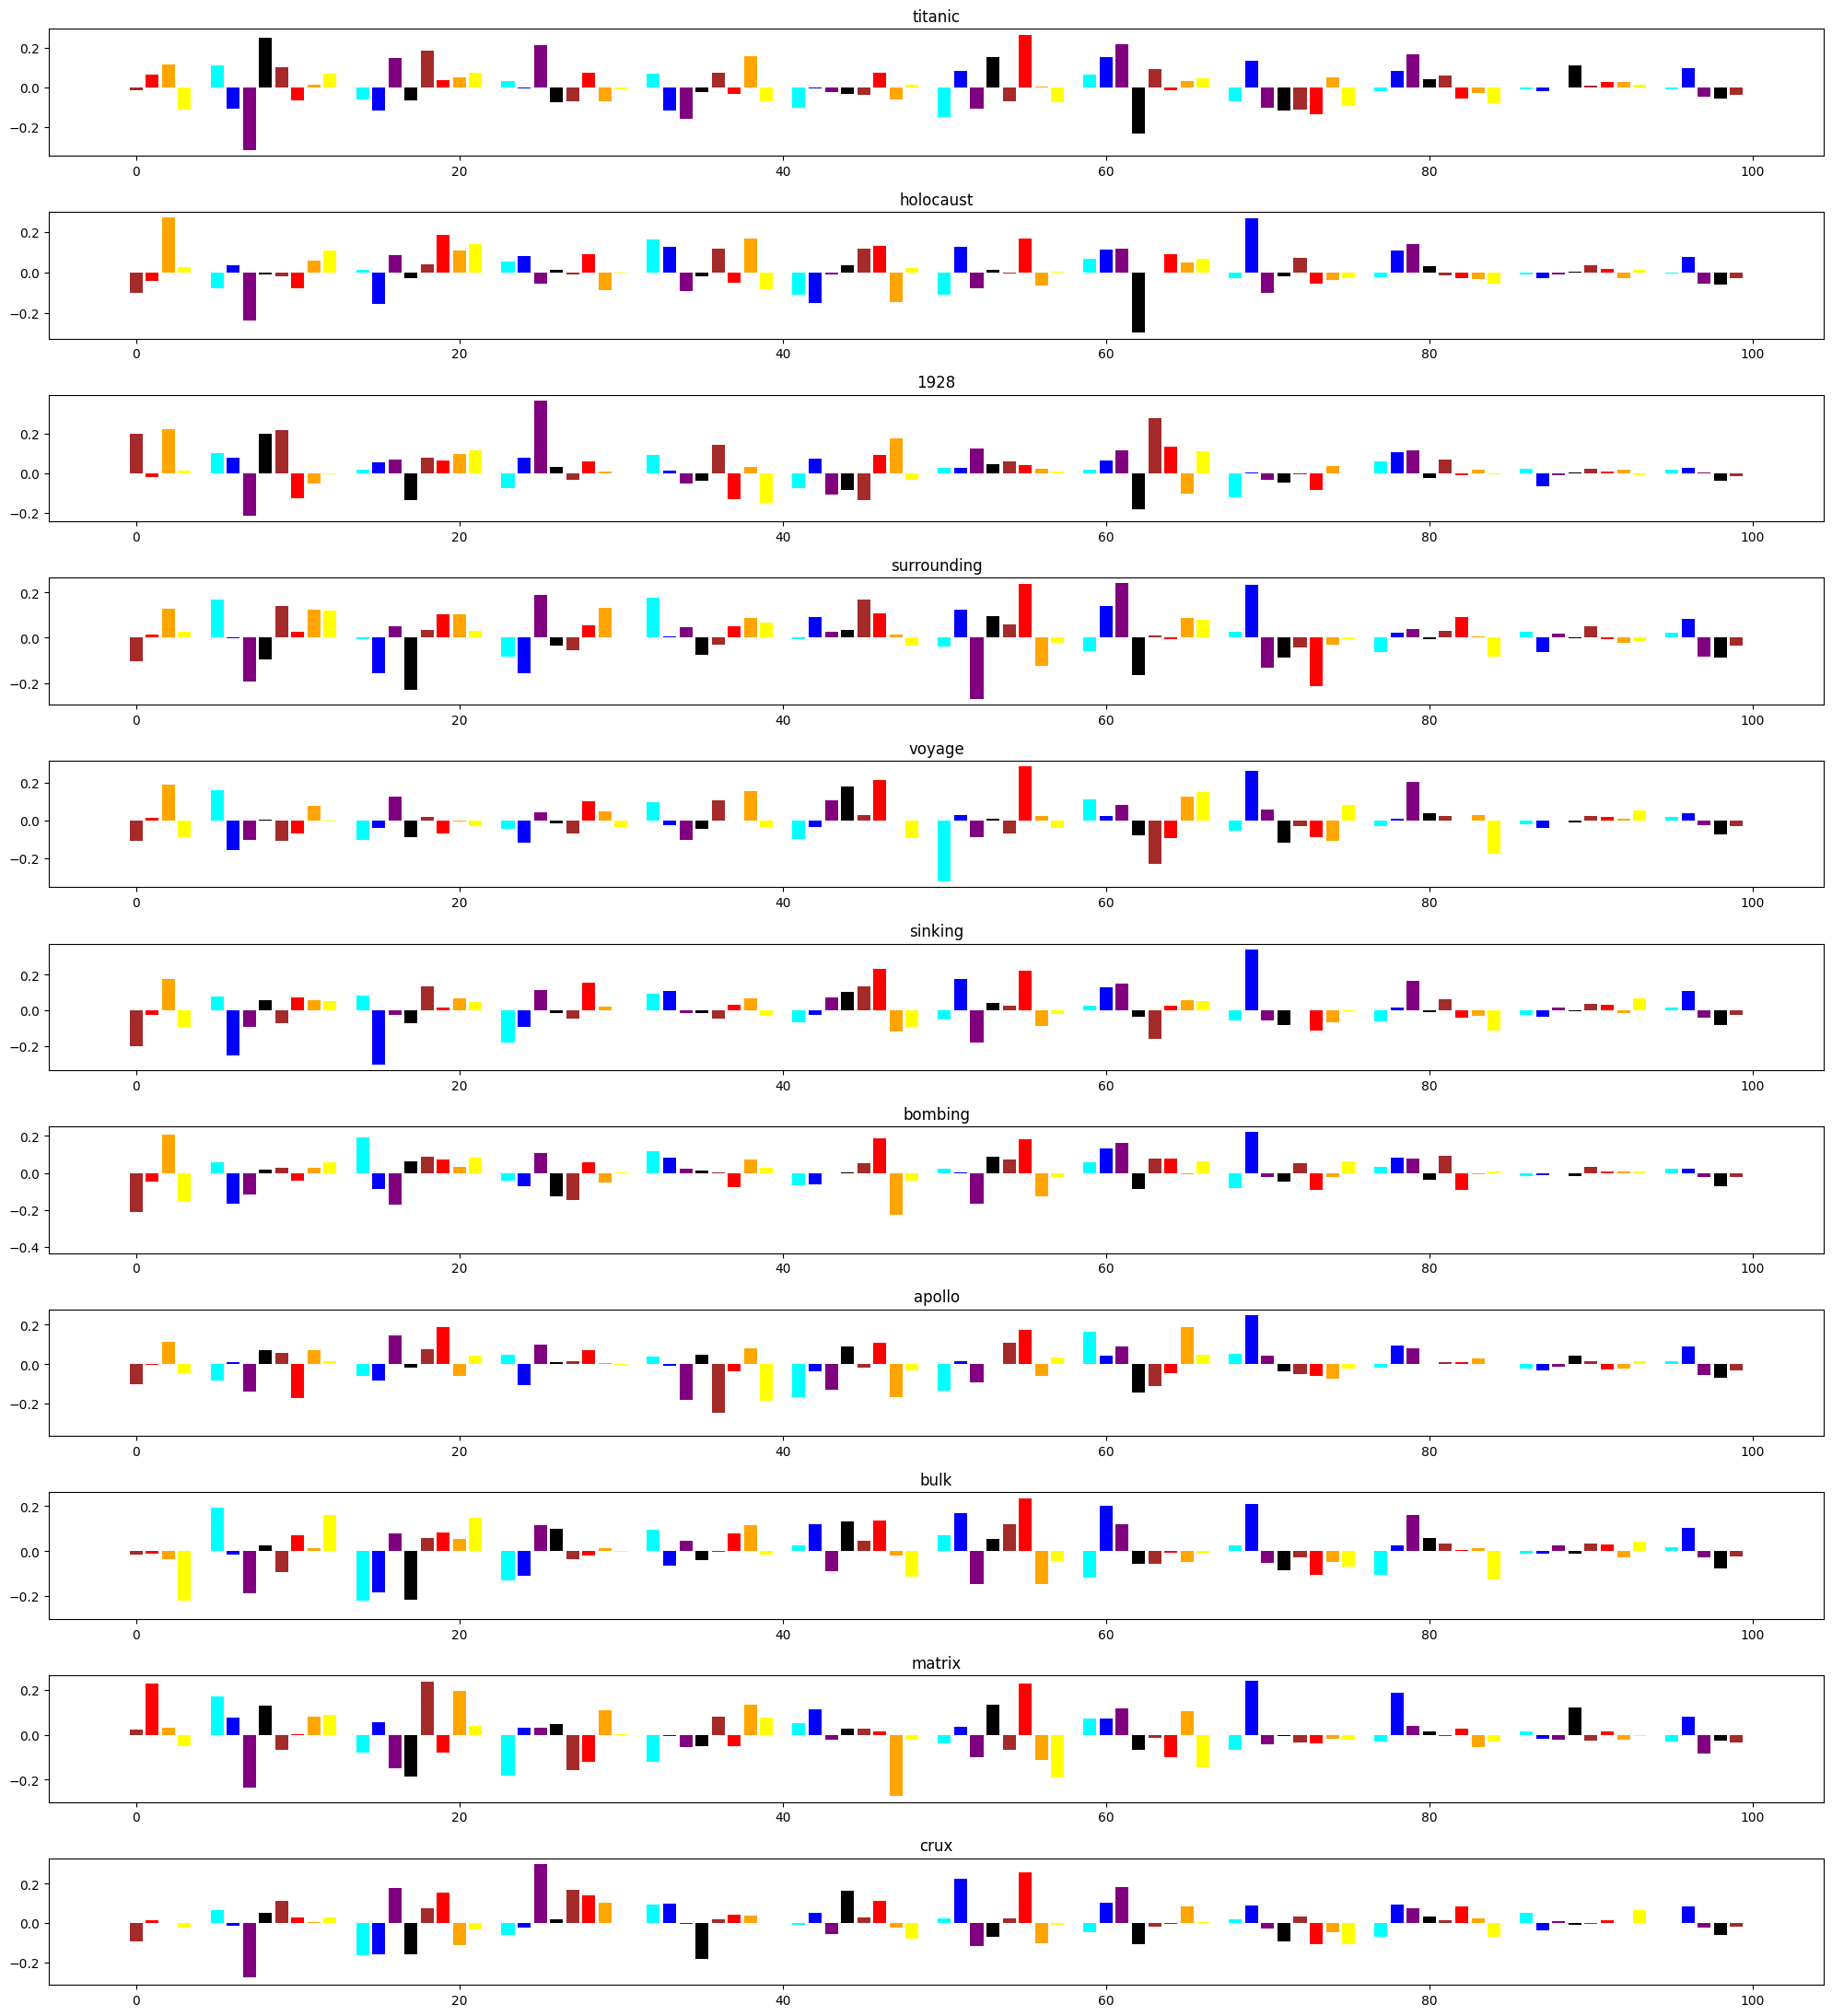

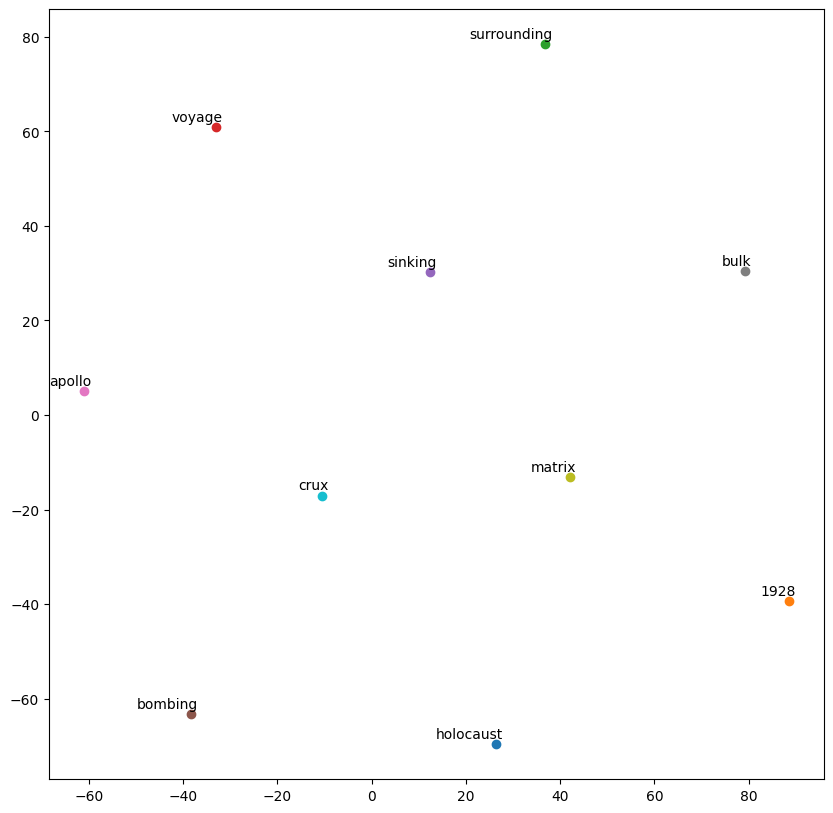

In [4]:
words = ['boat','review','her','great','smart','titanic']
for word in words:
    plot_top_10_words(word,feature_list,svd_matrix)


7346it [00:00, 25213.55it/s]


Word:  beautifully
Top 10 similar words:  ['wonderfully', 'masterfully', 'photographed', 'superbly', 'visually', 'expertly', 'brilliantly', 'powerfully', 'layered', 'poignant']


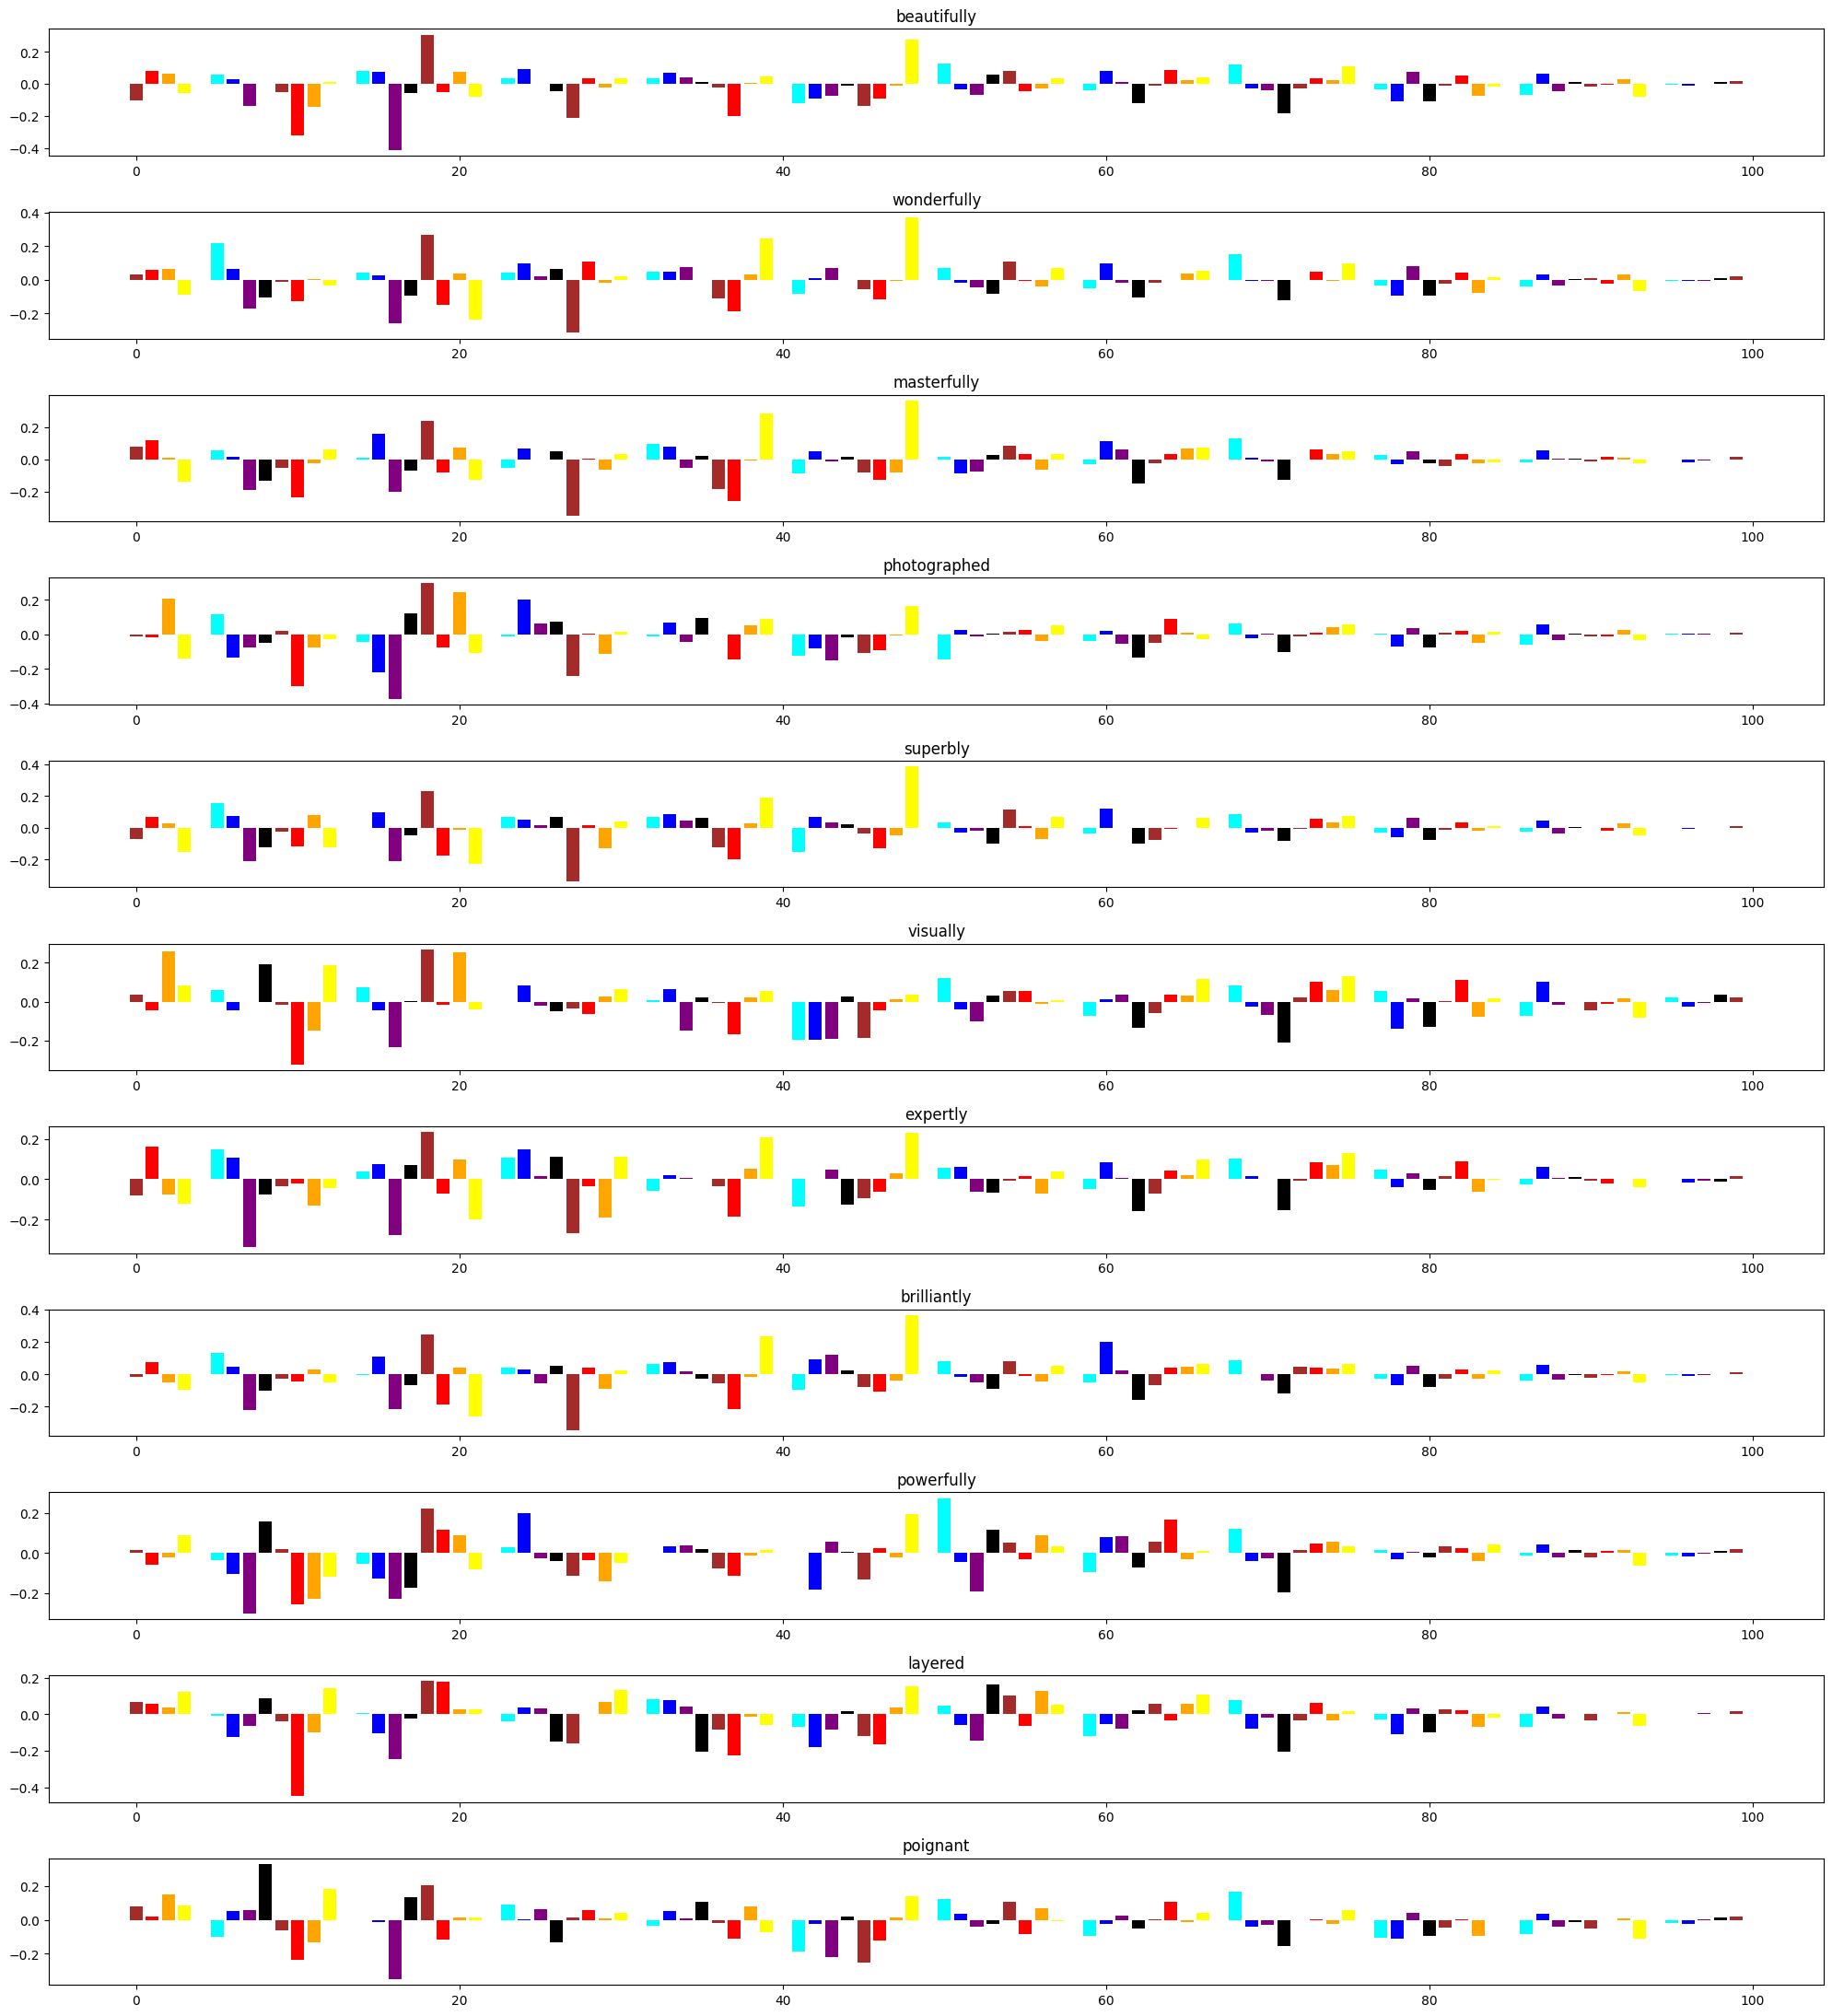

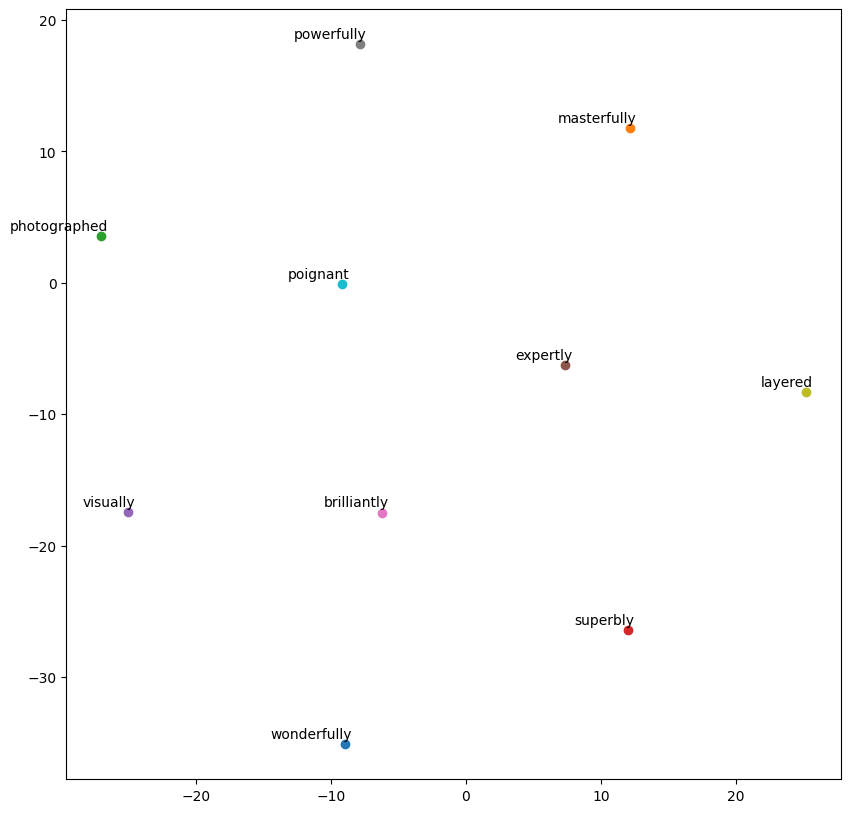

In [9]:
plot_top_10_words("beautifully", feature_list, svd_matrix)
